# Анализ данных
Построим модели по предсказанию уровня доходов в стране по показателям производительности сети.

## Setup
Оптимизируем дальнейший код и сразу заполним пространство всем необходимым функционалом.

In [1]:
import os
import logging

import pandas as pd
import numpy as np
import tensorflow as tf

import seaborn as sns

2023-05-31 19:37:49.761693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S',
                    force = True)


def check_folder(name: str) -> str:
    """If folder not exists - create, after return path"""

    if not os.path.exists(name):
        os.makedirs(name)

    return name

In [3]:
DATA_TYPE = 'light'
SERIAL_TYPE = 'mobile'

SEED = 0  # to reproduce building
BATCH_SIZE = 32

FIG_SIZE = (38.4,21.6)  # 3810x2160

DATA_PATH = f'data/{DATA_TYPE}'
LOGS_PATH = check_folder(f'logs/{DATA_TYPE}/{SERIAL_TYPE}')
MODEL_PATH = check_folder(f'model/{DATA_TYPE}/{SERIAL_TYPE}')
VISUAL_PATH = check_folder(f'visual/model/{DATA_TYPE}/{SERIAL_TYPE}')

In [4]:
sns.set_theme(palette='winter', font='jost', font_scale=3, rc={'figure.figsize': FIG_SIZE})

## Prepare
Загрузим датасет, отсортируем значения по годам и уровню доходов, уберём лишние признаки.

In [5]:
df = pd.read_csv(f'{DATA_PATH}/{SERIAL_TYPE}/{SERIAL_TYPE}_{DATA_TYPE}.csv').sort_values(by=['year', 'income'])
display(df)

,iso_a3,year,label,income,group,continent,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices
727,VEN,2019,Venezuela,84.341,Low income,South America,5023.000,2202.750000,106.0,62702,32357
755,ZWE,2019,Zimbabwe,369.445,Low income,Africa,9353.500,4488.333333,34.0,4661,2059
44,BDI,2019,Burundi,745.617,Low income,Africa,5618.750,3295.250000,32.0,1985,586
112,CAF,2019,Central African Republic,1005.373,Low income,Africa,2098.000,1828.000000,327.0,286,88
140,COD,2019,"Congo, Dem. Rep. of the",1112.838,Low income,Africa,8803.000,4081.000000,39.0,7283,2632
...,...,...,...,...,...,...,...,...,...,...,...
123,CHE,2022,Switzerland,82274.856,High income,Europe,75176.125,17461.500000,21.0,269875,144132
570,QAT,2022,Qatar,108635.329,High income,Asia,127482.000,24497.250000,20.5,59193,32028
598,SGP,2022,Singapore,119778.223,High income,Asia,117659.250,20044.375000,20.0,197619,100959
314,IRL,2022,Ireland,123764.551,High income,Europe,20673.000,6561.000000,26.5,315754,156322


Сбалансируем датасет, приведя группы к единому размеру и сократив его до 200 000 наблюдений на группу:

In [6]:
# df = pd.concat([df_group[1].sample(n=50_000, random_state=SEED) for df_group in df.groupby(['group', 'year'], sort=False)])
df.groupby('group').describe().round(2).T

group             High income  Low income  Lower-middle income   
year       count       192.00      191.00               184.00  \
           mean       2020.50     2020.51              2020.50   
           std           1.12        1.12                 1.12   
           min        2019.00     2019.00              2019.00   
           25%        2019.75     2020.00              2019.75   
           50%        2020.50     2021.00              2020.50   
           75%        2021.25     2021.50              2021.25   
           max        2022.00     2022.00              2022.00   
income     count       192.00      191.00               184.00   
           mean      56131.82     2612.08              9200.78   
           std       20278.40     1217.39              2753.72   
           min       32443.92       84.34              4790.26   
           25%       42382.31     1564.60              6221.98   
           50%       51687.02     2403.16              9426.28   
           75%       61527.85     3637.55             11635.19   
           max      130002.86     5124.90             13921.40   
avg_d_kbps count       192.00      191.00               184.00   
           mean      46358.06    11436.25             15895.68   
           std       26175.22     6551.41              7087.90   
           min       12563.75      235.00              2530.00   
           25%       28338.38     7276.50             11410.50   
           50%       39698.04    10239.00             14841.25   
           75%       55280.00    14878.79             20215.50   
           max      154569.00    36128.50             49410.00   
avg_u_kbps count       192.00      191.00               184.00   
           mean      11734.34     5847.88              7671.69   
           std        4822.02     3484.22              3160.85   
           min        4362.12       48.50              1435.50   
           25%        8123.75     3418.88              5372.50   
           50%       10519.69     5325.00              7333.38   
           75%       14378.94     7901.25              9564.03   
           max       31237.50    20227.00             19272.00   
avg_lat_ms count       192.00      191.00               184.00   
           mean         27.40       66.48                38.67   
           std           7.68      124.34                36.55   
           min          15.00       18.00                16.00   
           25%          21.92       26.00                25.00   
           50%          25.71       32.00                31.00   
           75%          30.06       45.12                37.00   
           max          52.75      868.00               351.00   
tests      count       192.00      191.00               184.00   
           mean     771611.69    21396.55            767594.51   
           std     1725668.84    62763.06           2779076.92   
           min         439.00        1.00                89.00   
           25%       72750.25     1307.00              7800.25   
           50%      189462.00     5262.00             56133.50   
           75%      637578.25    14208.00            272145.25   
           max    11669201.00   669742.00          21272790.00   
devices    count       192.00      191.00               184.00   
           mean     373270.52     8470.85            333347.35   
           std      817611.37    22257.67           1170934.81   
           min         308.00        1.00                35.00   
           25%       39049.00      545.50              3099.00   
           50%      102619.00     2059.00             31337.50   
           75%      306546.25     5143.50            150283.50   
           max     5596551.00   190640.00           8327567.00   

group             Upper-middle income  
year       count               192.00  
           mean               2020.50  
           std                   1.12  
           min                2019.00  
           25%                2019.75

Категоризируем целевой признак `group`:

In [7]:
values, groups = pd.factorize(df.pop('group'))
df['group'] = values

print('\n'.join(f'{n} - {v}' for n, v in enumerate(groups)))

0 - Low income
1 - Lower-middle income
2 - Upper-middle income
3 - High income


Категоризируем качественный признак `continent` и переведём его в dummy-переменную:

In [8]:
values, continents = pd.factorize(df.pop('continent'))
df = pd.concat([df, pd.DataFrame(tf.keras.utils.to_categorical(values, dtype='int8'), index=df.index, columns=continents)], axis=1)

print('\n'.join(f'{n} - {v}' for n, v in enumerate(continents)))

0 - South America
1 - Africa
2 - Oceania
3 - Asia
4 - North America
5 - Europe
6 - Seven seas (open ocean)


Уберём лишние колонки и перетасуем полученный датасет:

In [9]:
df = df.drop(columns=['iso_a3', 'label', 'income']).sample(frac=1, random_state=SEED)
display(df)

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
698,2022,75634.875000,14486.750000,22.00,3408184,1337363,3,0,0,0,1,0,0,0
206,2022,5184.000000,2089.000000,304.00,13,9,0,0,1,0,0,0,0,0
470,2022,14215.000000,11052.000000,33.50,27712,9848,0,0,1,0,0,0,0,0
623,2019,2881.125000,1733.000000,37.00,436,134,0,0,1,0,0,0,0,0
248,2020,8474.500000,3997.000000,33.00,20264,7821,1,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,2022,27464.000000,9150.250000,23.00,102724,60164,2,0,0,0,0,0,1,0
113,2020,6502.000000,3167.625000,287.00,371,88,0,0,1,0,0,0,0,0
382,2022,25377.625000,13278.500000,29.00,175950,54939,1,0,0,0,1,0,0,0
102,2021,44707.375000,19670.375000,16.75,14996,7947,3,0,0,0,1,0,0,0


Построим корреляционную матрицу и посмотрим, насколько связаны полученные признаки:

In [10]:
df_corr = df.corr(method='spearman').round(2)
df_corr

,year,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,group,South America,Africa,Oceania,Asia,North America,Europe,Seven seas (open ocean)
year,1.00,0.21,0.20,-0.18,0.03,0.02,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00
avg_d_kbps,0.21,1.00,0.78,-0.49,0.33,0.34,0.73,-0.12,-0.42,-0.08,0.07,0.06,0.44,0.06
avg_u_kbps,0.20,0.78,1.00,-0.52,0.24,0.25,0.49,-0.07,-0.27,-0.06,0.20,-0.07,0.19,0.11
avg_lat_ms,-0.18,-0.49,-0.52,1.00,0.00,0.00,-0.28,0.16,0.14,0.07,-0.11,0.10,-0.20,-0.17
tests,0.03,0.33,0.24,0.00,1.00,1.00,0.47,0.12,-0.38,-0.31,0.32,-0.09,0.31,-0.12
devices,0.02,0.34,0.25,0.00,1.00,1.00,0.50,0.13,-0.41,-0.30,0.31,-0.08,0.33,-0.11
group,-0.00,0.73,0.49,-0.28,0.47,0.50,1.00,-0.02,-0.57,-0.17,0.12,0.10,0.51,0.05
South America,-0.00,-0.12,-0.07,0.16,0.12,0.13,-0.02,1.00,-0.16,-0.07,-0.14,-0.10,-0.14,-0.03
Africa,0.00,-0.42,-0.27,0.14,-0.38,-0.41,-0.57,-0.16,1.00,-0.17,-0.34,-0.23,-0.32,-0.08
Oceania,-0.00,-0.08,-0.06,0.07,-0.31,-0.30,-0.17,-0.07,-0.17,1.00,-0.16,-0.11,-0.15,-0.04


Выведем данную матрицу на тепловую карту:

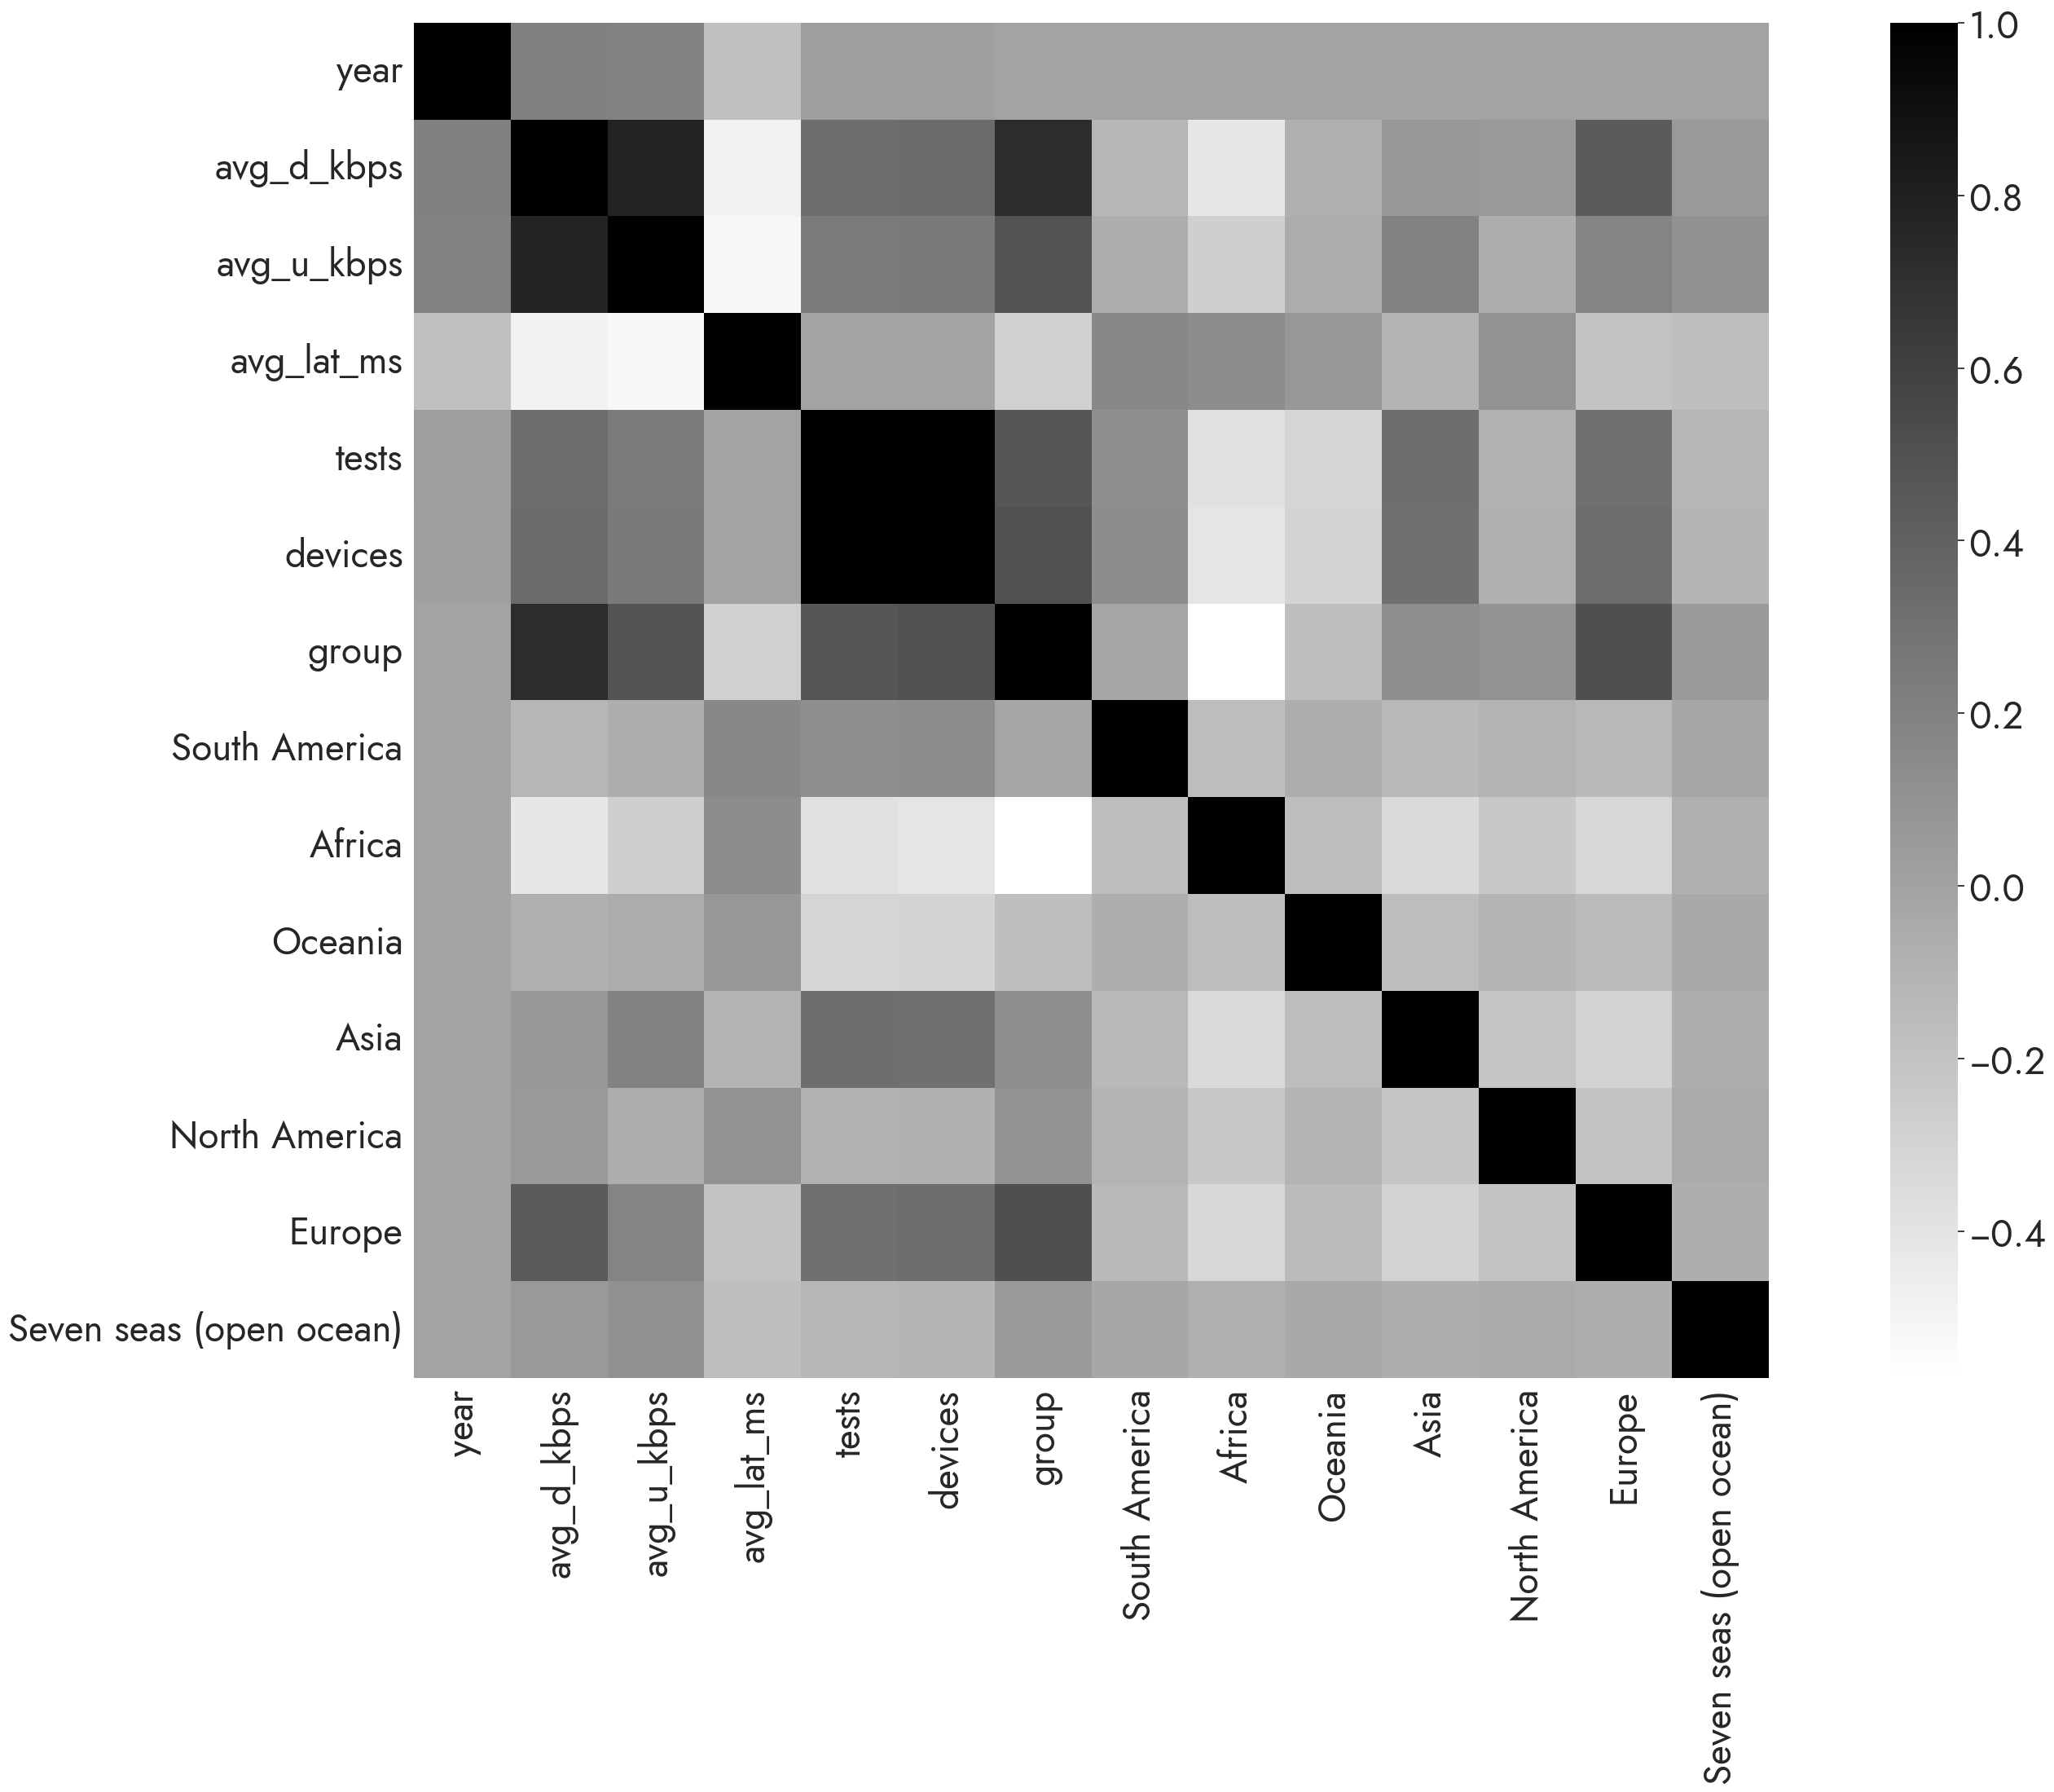

In [11]:
df_plot_corr = sns.heatmap(df_corr, cmap='gray_r', square=True);

In [12]:
df_plot_corr.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_corr.png', transparent=True)

Разделим датасет на обучающий набор - 80%, и на тестовый - 20%:

In [13]:
train_df = df.sample(frac=0.8, random_state=SEED)
test_df = df.drop(train_df.index)

print(f'{len(train_df)} training examples')
print(f'{len(test_df)} training examples')

607 training examples
152 training examples


Выделим целевой признак и преобразуем его в бинарную dummy-переменную.

In [14]:
train_features = train_df.copy()
train_target = train_features.pop('group')

In [15]:
test_features = test_df.copy()
test_target = test_features.pop('group')

## Linear Machine Learning
Построим несколько моделей, основанных на линейных методах машинного обучения.

In [16]:
def fit_and_plot(model, arg: str, epochs: range | list = range(1, 101), patience: int = 5, **kwargs):
    histories = []

    for epoch in epochs:
        print(f'Epoch {epoch}/{len(epochs)}')

        epoch_model = model(**{arg: epoch}, **kwargs)
        epoch_model.fit(train_features, train_target)

        score = epoch_model.score(train_features, train_target)
        test_score = epoch_model.score(test_features, test_target)

        histories.append({'model': epoch_model, 'score': score, 'test_score': test_score})

        print(f'score: {round(score, 4)} - test_score: {round(test_score, 4)}')

        if epoch > 10 and test_score < sum(history['test_score'] for history in histories[-patience:]) / patience:
            print(f'Epoch {epoch}: early stopping')
            break

    history_plot = sns.lineplot(data=pd.DataFrame(histories)[['score', 'test_score']], linewidth=5)

    history_plot.set_xlabel('epoch')
    history_plot.set_ylabel('score')

    return max(histories, key=lambda history: history['test_score']), history_plot

### k-neighbors
Обучим модель с методом классификации k-ближайших соседей.

Epoch 1/100
score: 1.0 - test_score: 0.5658
Epoch 2/100
score: 0.7941 - test_score: 0.5395
Epoch 3/100
score: 0.7529 - test_score: 0.5395
Epoch 4/100
score: 0.7463 - test_score: 0.4934
Epoch 5/100
score: 0.7166 - test_score: 0.5
Epoch 6/100
score: 0.7035 - test_score: 0.4671
Epoch 7/100
score: 0.6952 - test_score: 0.4934
Epoch 8/100
score: 0.6903 - test_score: 0.4868
Epoch 9/100
score: 0.6804 - test_score: 0.5395
Epoch 10/100
score: 0.6672 - test_score: 0.5395
Epoch 11/100
score: 0.6656 - test_score: 0.5197
Epoch 12/100
score: 0.6639 - test_score: 0.4934
Epoch 12: early stopping


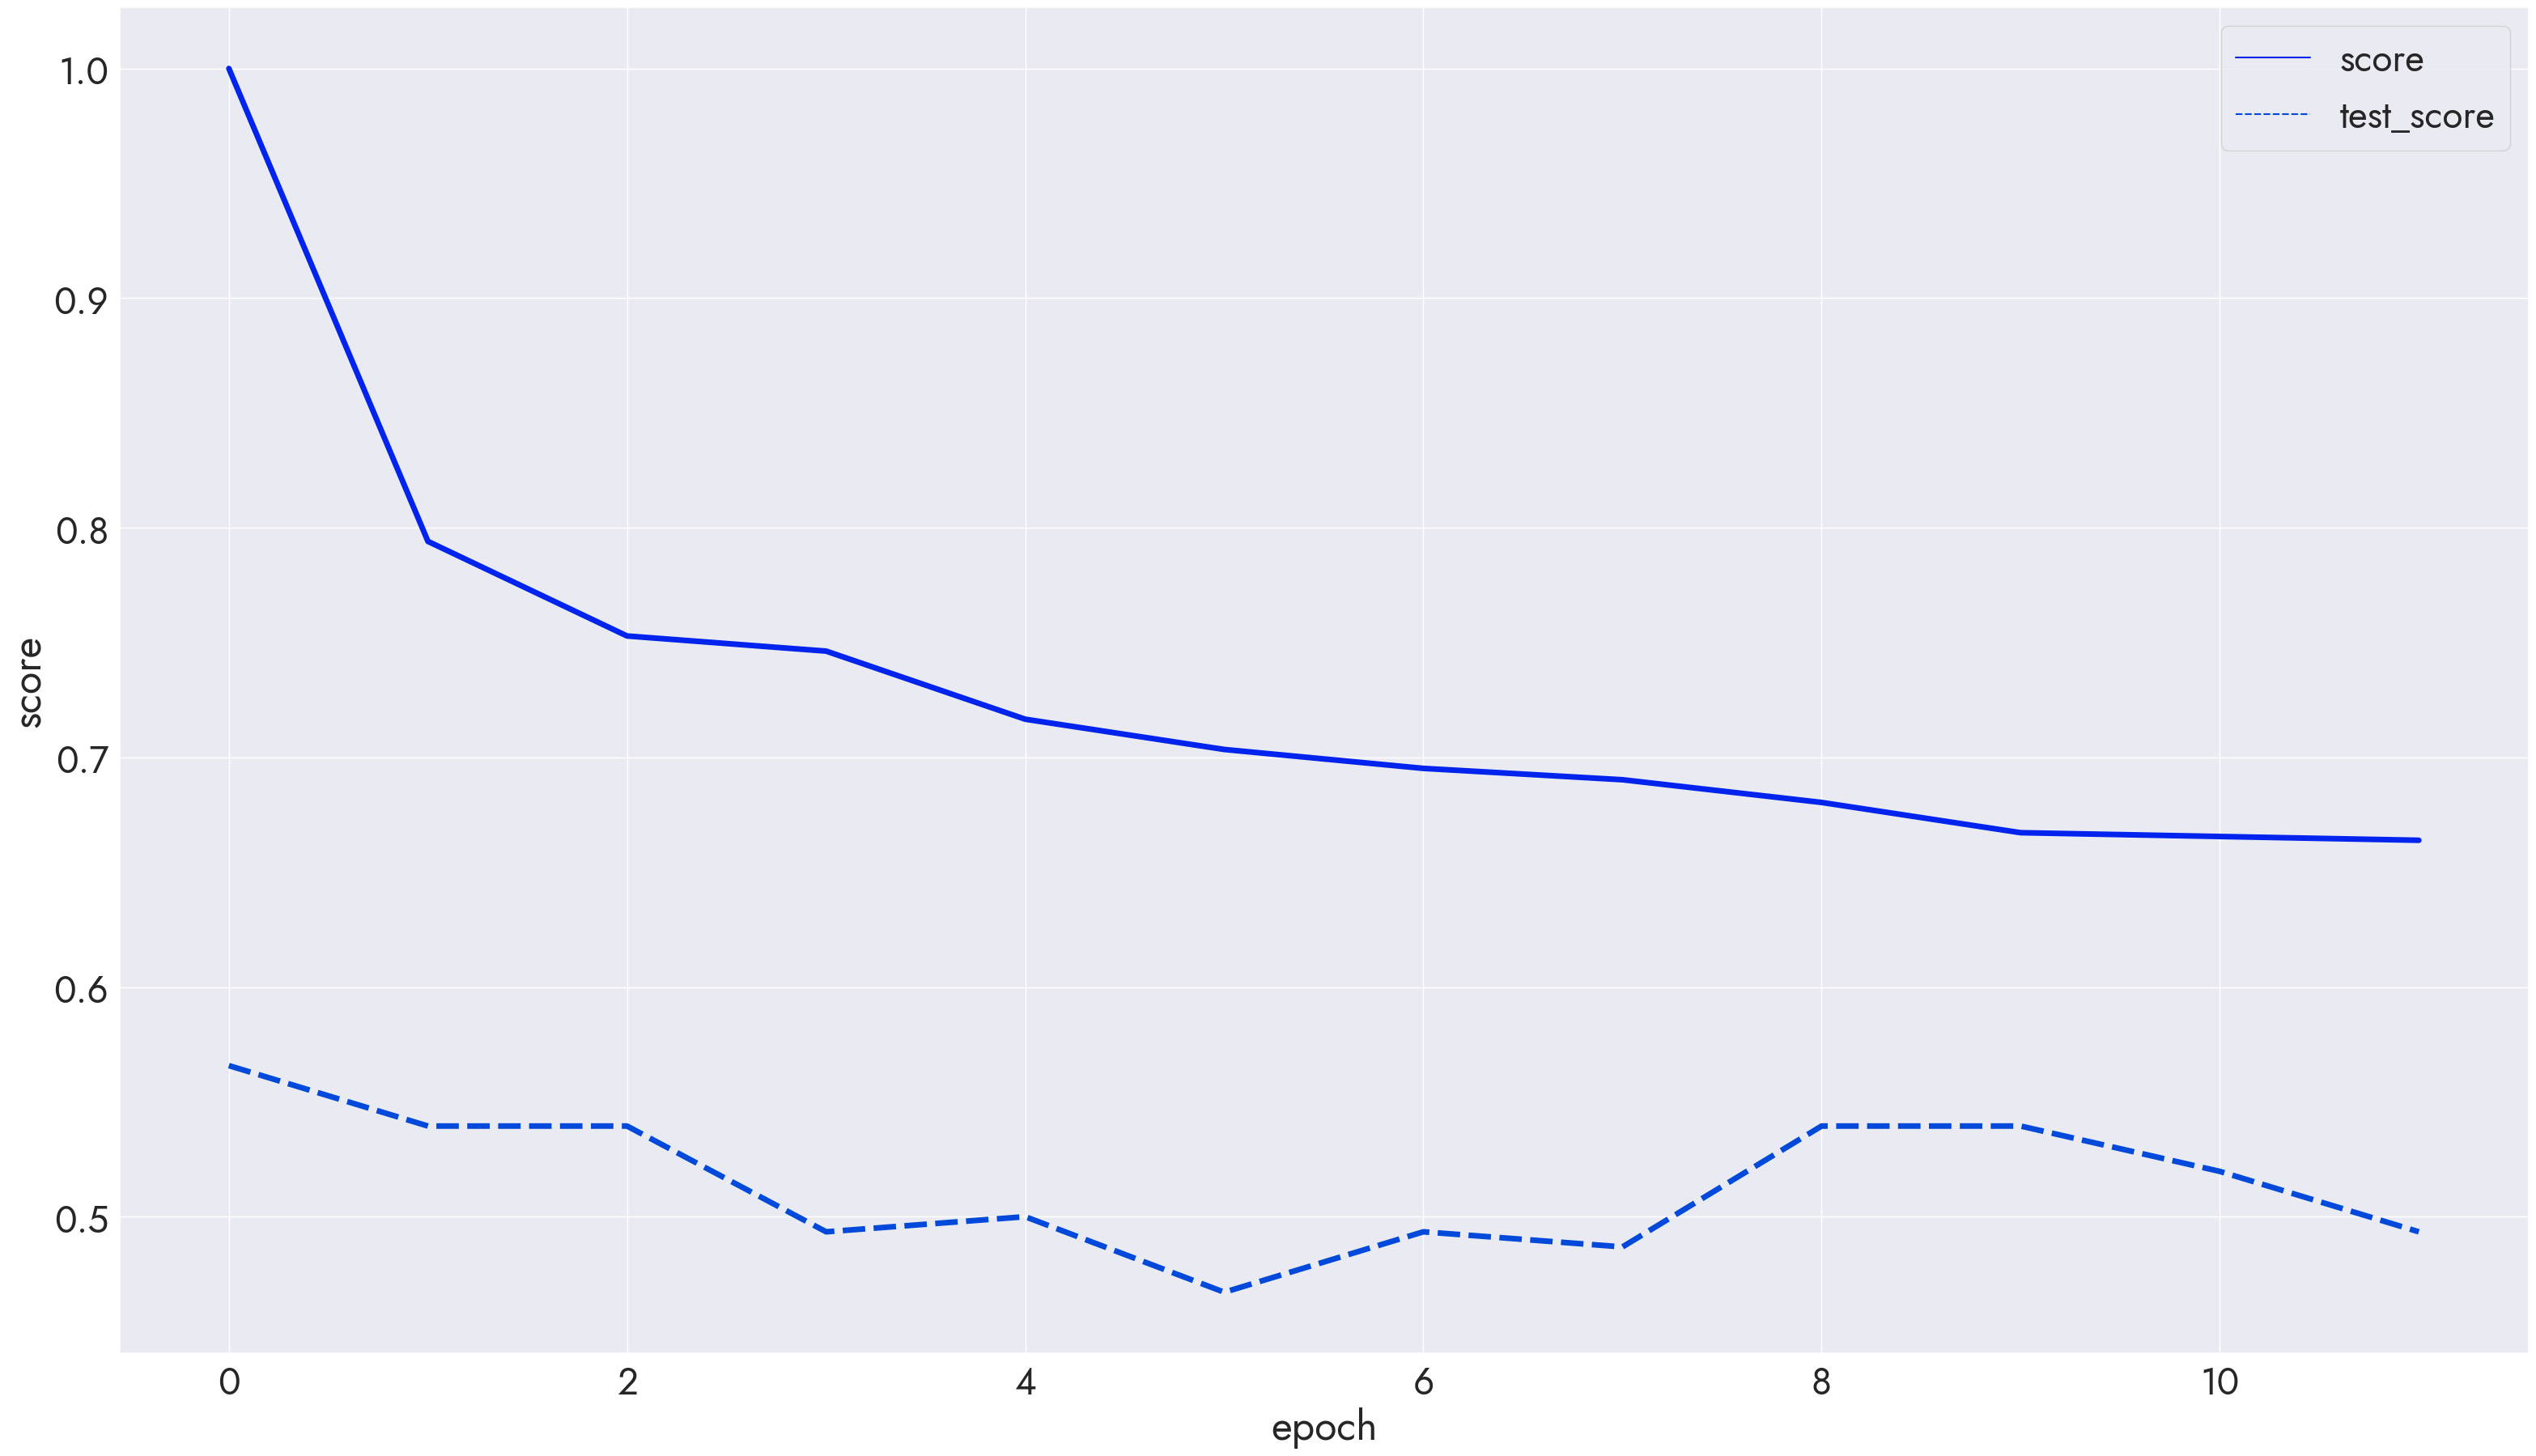

In [17]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors_model, k_neighbors_plot_history = fit_and_plot(KNeighborsClassifier, arg='n_neighbors')

In [18]:
k_neighbors_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_k_neighbors.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [19]:
print(f"score: {round(k_neighbors_model['score'], 4)}")

score: 1.0


In [20]:
print(f"score: {round(k_neighbors_model['test_score'], 4)}")

score: 0.5658


### decision tree
Обучим модель с методом классификации дерева решений

Epoch 1/100
score: 0.4185 - test_score: 0.4013
Epoch 2/100
score: 0.5535 - test_score: 0.5
Epoch 3/100
score: 0.6359 - test_score: 0.5329
Epoch 4/100
score: 0.6886 - test_score: 0.5461
Epoch 5/100
score: 0.7216 - test_score: 0.5658
Epoch 6/100
score: 0.7512 - test_score: 0.5395
Epoch 7/100
score: 0.7891 - test_score: 0.5789
Epoch 8/100
score: 0.8633 - test_score: 0.6118
Epoch 9/100
score: 0.9143 - test_score: 0.6118
Epoch 10/100
score: 0.9572 - test_score: 0.6447
Epoch 11/100
score: 0.9769 - test_score: 0.6118
Epoch 11: early stopping


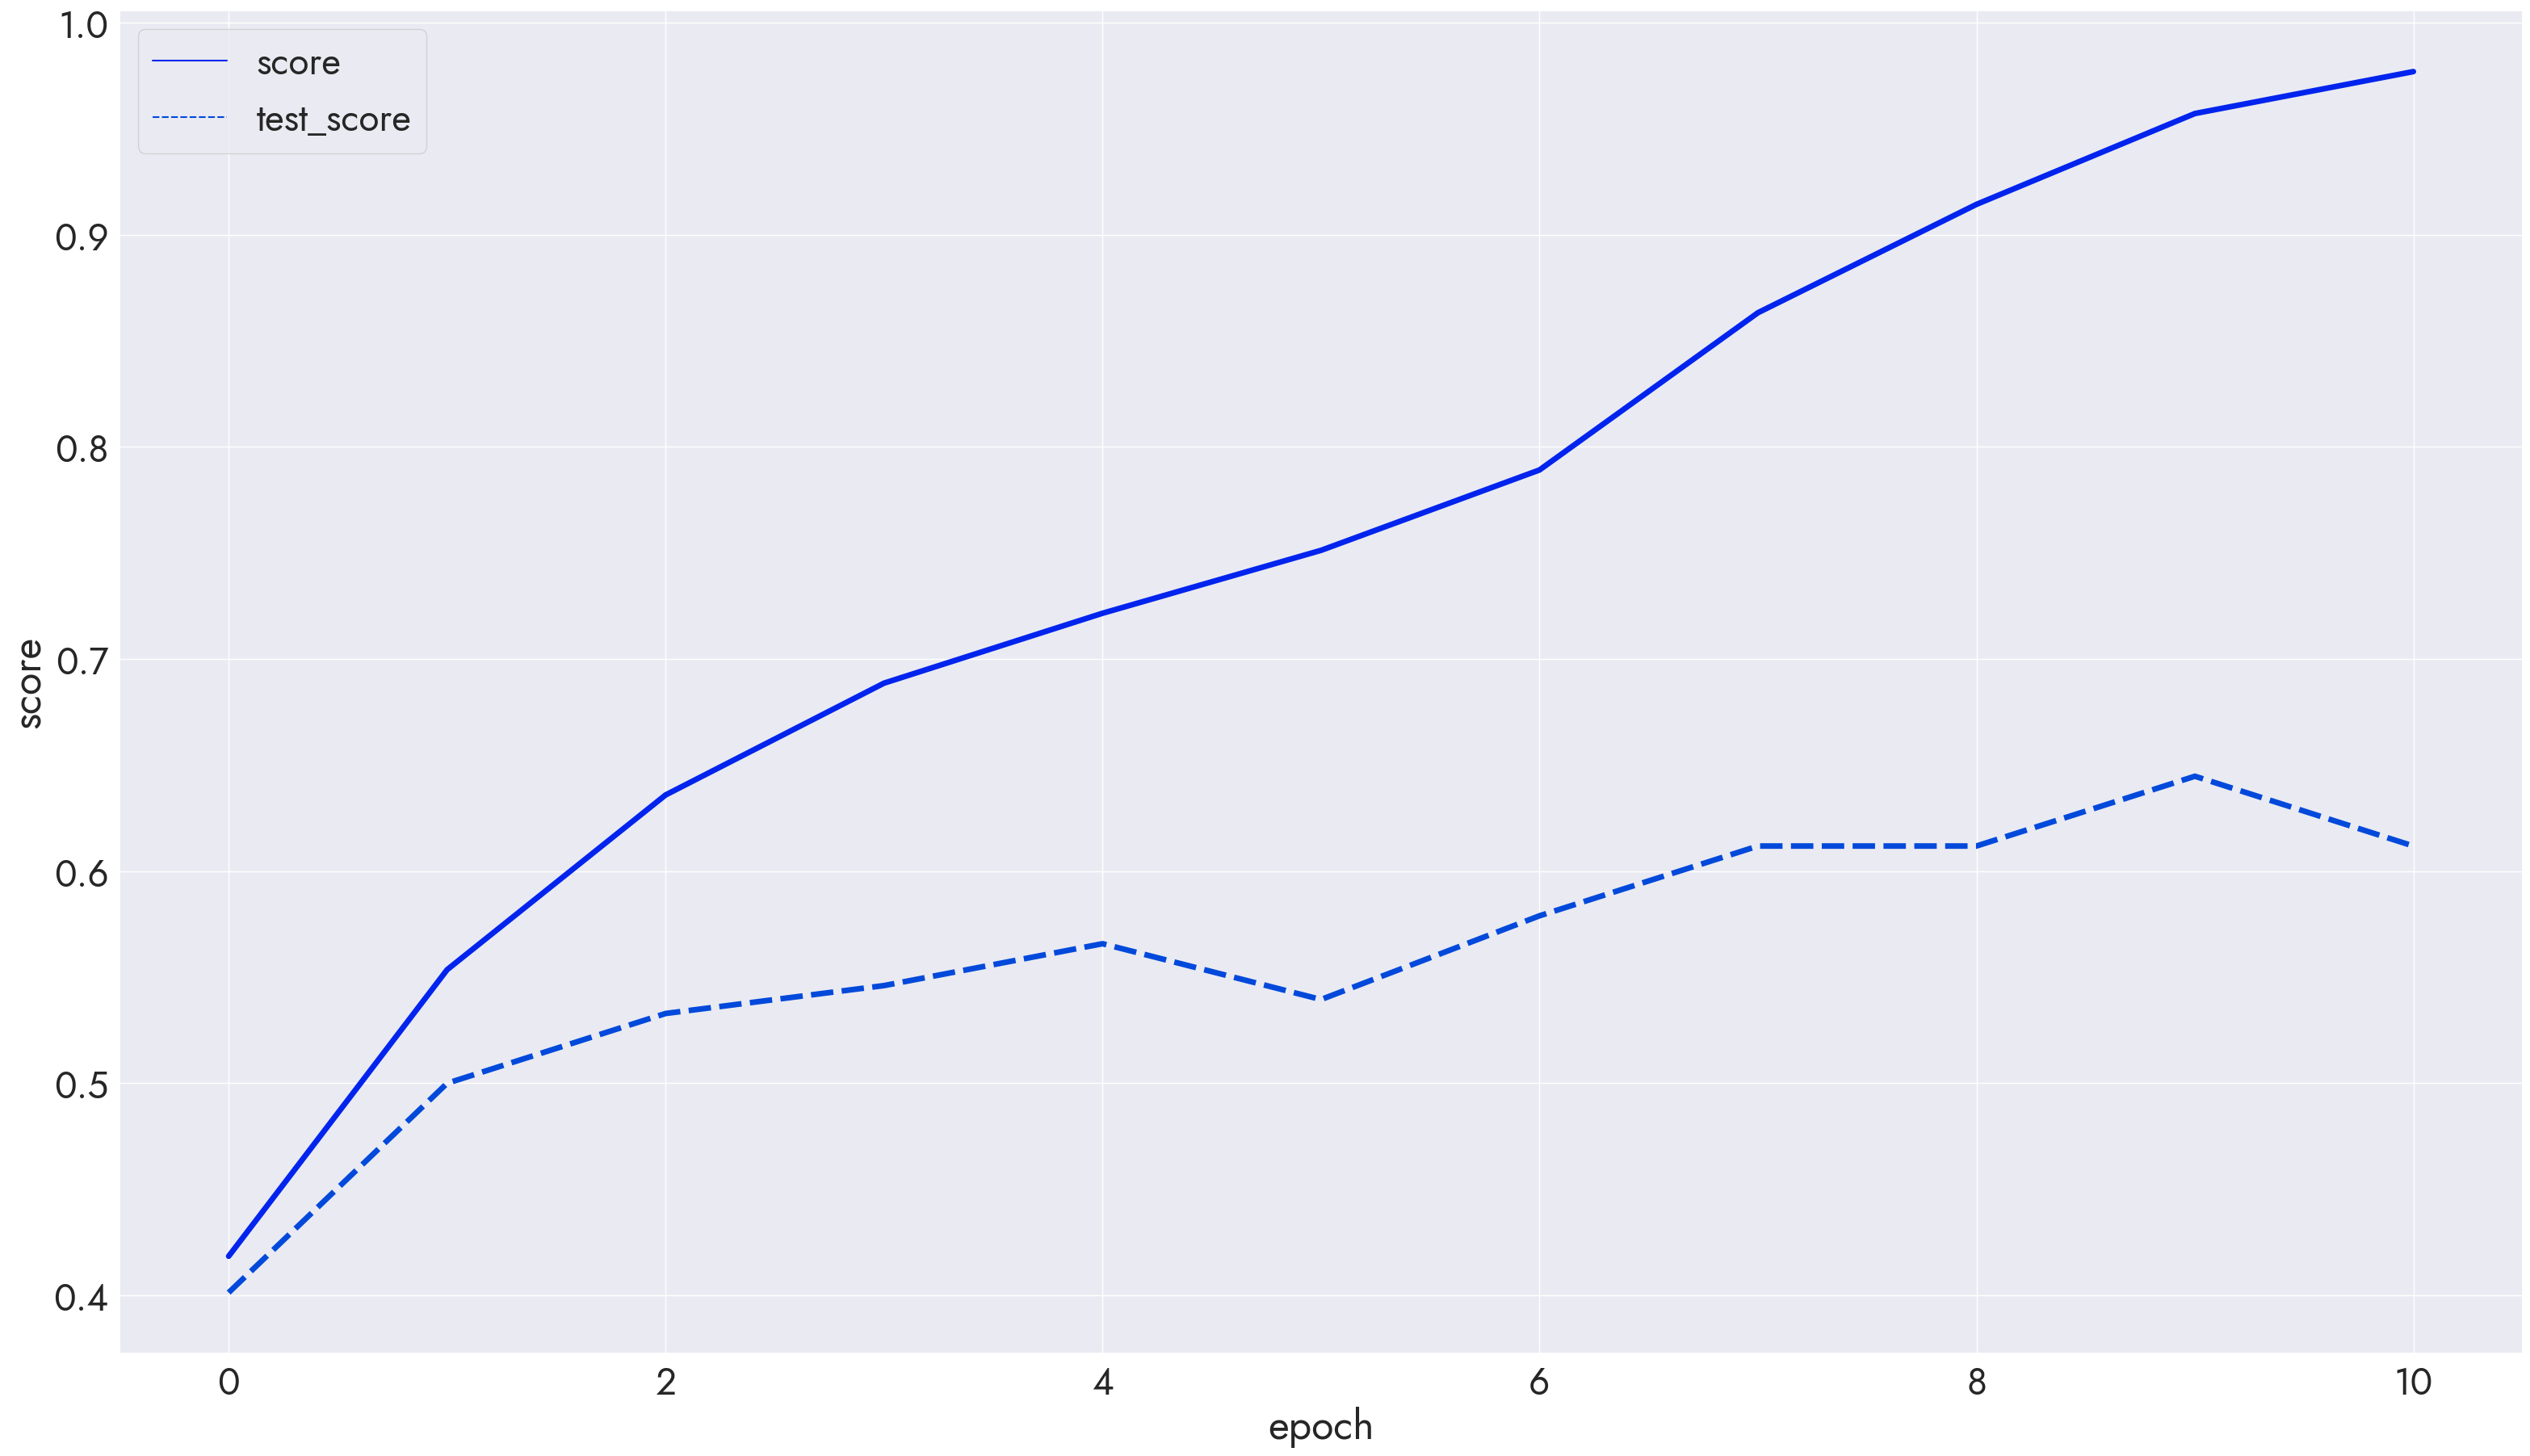

In [21]:
from sklearn.tree import DecisionTreeClassifier
decision_tree_model, decision_tree_plot_history = fit_and_plot(DecisionTreeClassifier, arg='max_depth', random_state=SEED)

In [22]:
decision_tree_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_decision_tree.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [23]:
print(f"score: {round(decision_tree_model['score'], 4)}")

score: 0.9572


In [24]:
print(f"score: {round(decision_tree_model['test_score'], 4)}")

score: 0.6447


### svc
Обучим модель с методом классификации дерева решений

Epoch 1/100
score: 0.3756 - test_score: 0.3553
Epoch 2/100
score: 0.3707 - test_score: 0.3684
Epoch 3/100
score: 0.3839 - test_score: 0.3882
Epoch 4/100
score: 0.3954 - test_score: 0.4211
Epoch 5/100
score: 0.402 - test_score: 0.4342
Epoch 6/100
score: 0.4102 - test_score: 0.4408
Epoch 7/100
score: 0.4135 - test_score: 0.4342
Epoch 8/100
score: 0.4283 - test_score: 0.4342
Epoch 9/100
score: 0.4366 - test_score: 0.4474
Epoch 10/100
score: 0.43 - test_score: 0.4408
Epoch 11/100
score: 0.4283 - test_score: 0.4539
Epoch 12/100
score: 0.4349 - test_score: 0.4605
Epoch 13/100
score: 0.4333 - test_score: 0.4342
Epoch 13: early stopping


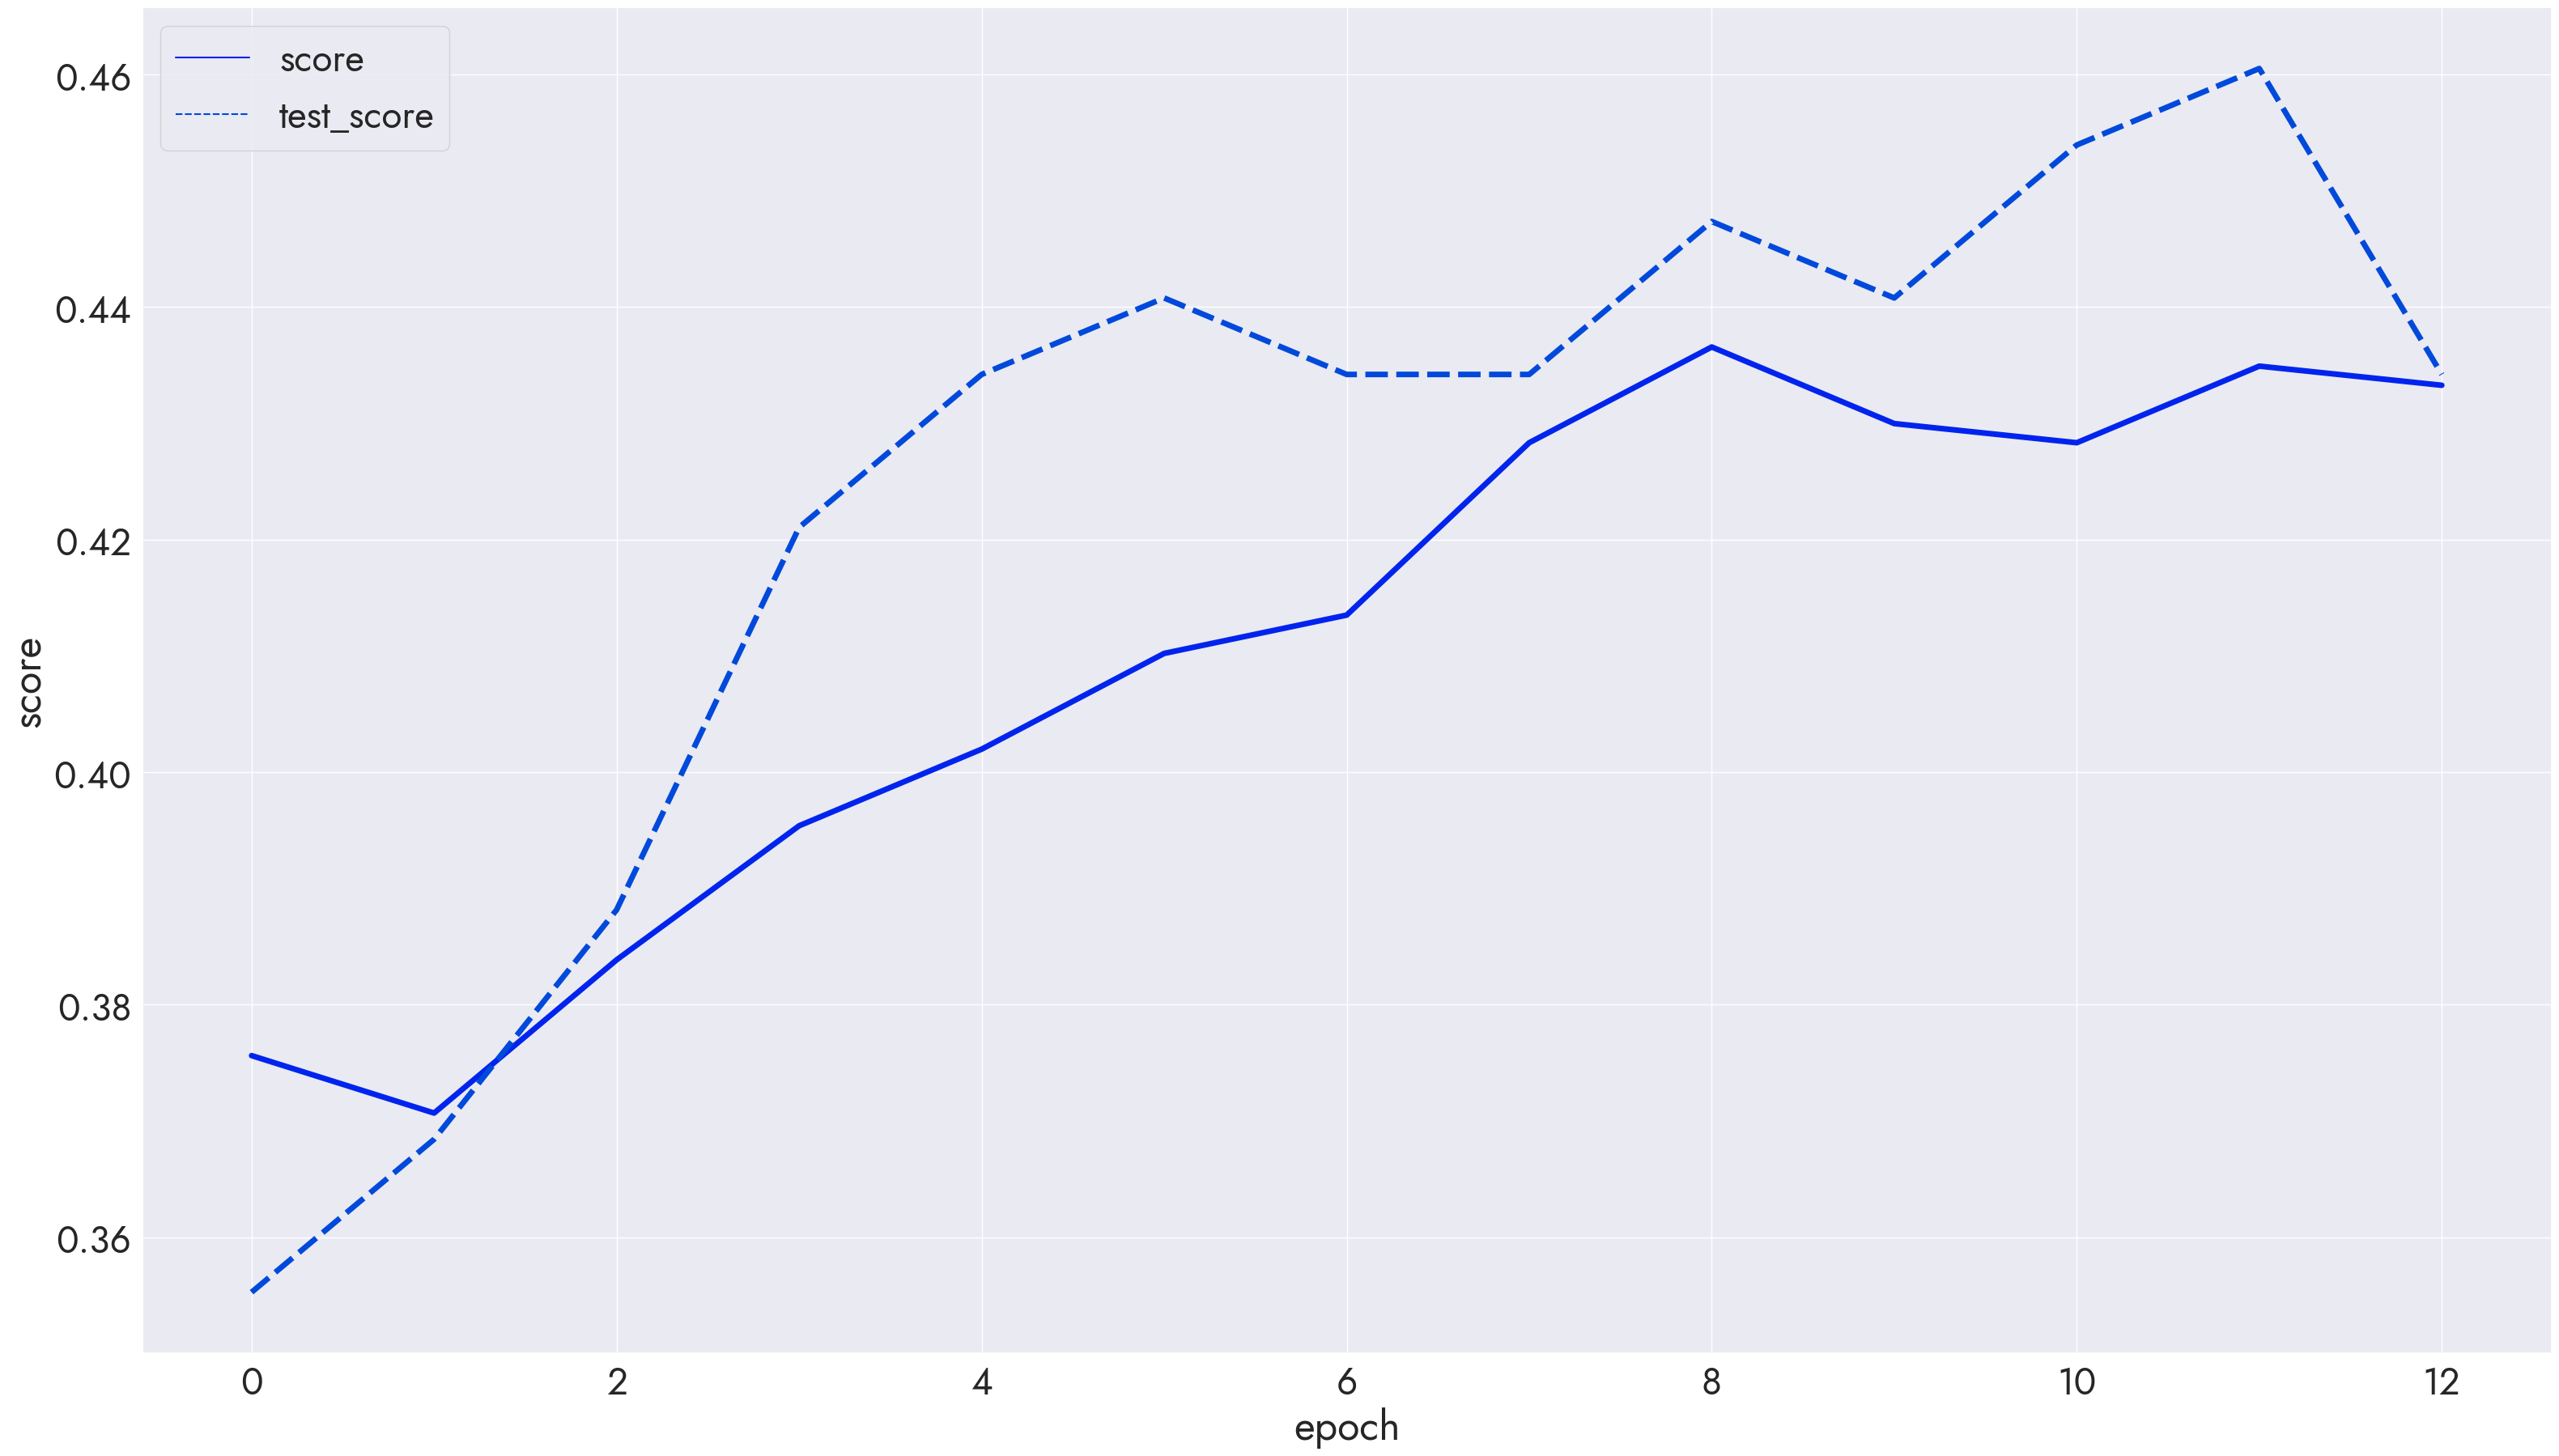

In [25]:
from sklearn.svm import SVC
svc_model, svc_plot_history = fit_and_plot(SVC, arg='C', random_state=SEED)

In [26]:
svc_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_svc.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [27]:
print(f"score: {round(svc_model['score'], 4)}")

score: 0.4349


In [28]:
print(f"score: {round(svc_model['test_score'], 4)}")

score: 0.4605


### finally
Проанализируем модель, имеющую наибольшую точность предсказаний на тестовой выборке.

In [29]:
linear_model = decision_tree_model['model']

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [30]:
test_predict = pd.Series(linear_model.predict(test_features), index=test_df.index)

Рассмотрим распределение предсказаний модели по группам:

In [31]:
from sklearn.metrics import confusion_matrix

linear_dist = pd.DataFrame(confusion_matrix(test_target, test_predict),
                        index=groups, columns=groups)
linear_dist

,Low income,Lower-middle income,Upper-middle income,High income
Low income,28,4,6,0
Lower-middle income,10,20,5,4
Upper-middle income,7,6,20,7
High income,0,0,5,30


Выведем данную таблицу на тепловую карту:

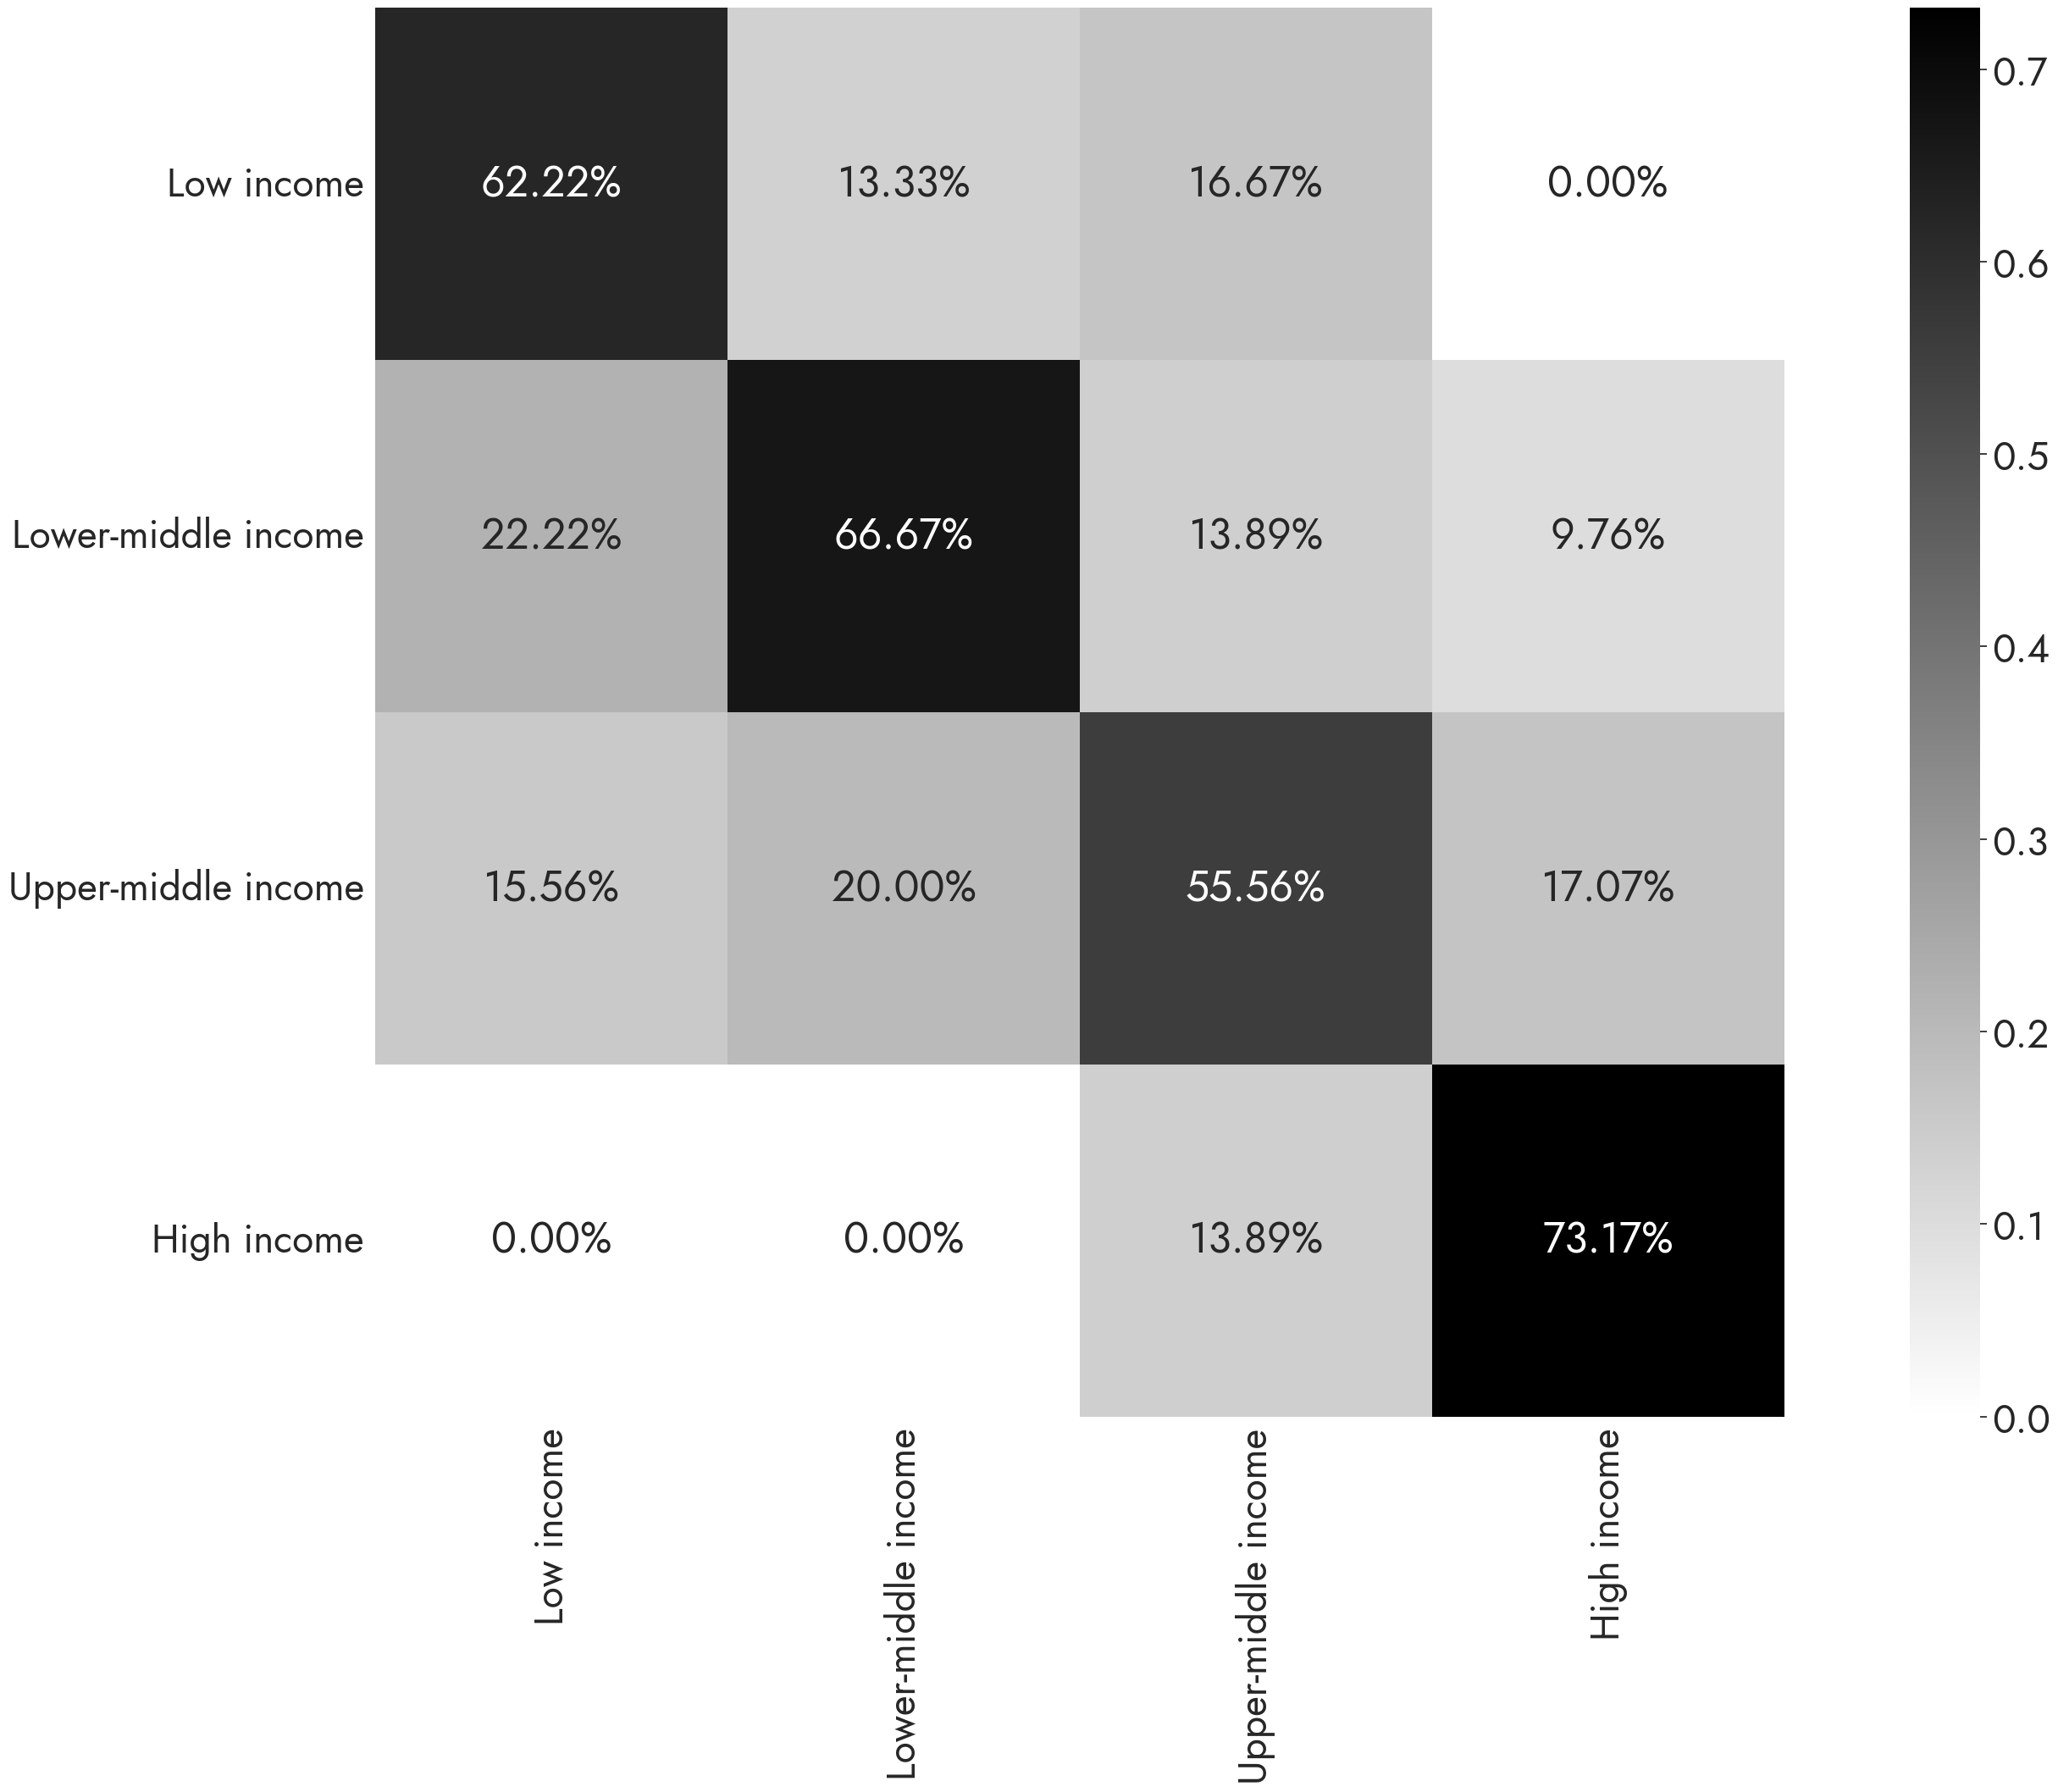

In [32]:
linear_plot_dist = sns.heatmap(linear_dist / linear_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

linear_plot_dist.set_xlabel(None);

In [33]:
linear_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_dist_linear.png', transparent=True)

Как видно по сводной таблице и по графику, модель в большинстве случаев неверно определяет группу.
Визуализируем распределение ошибок в модели:

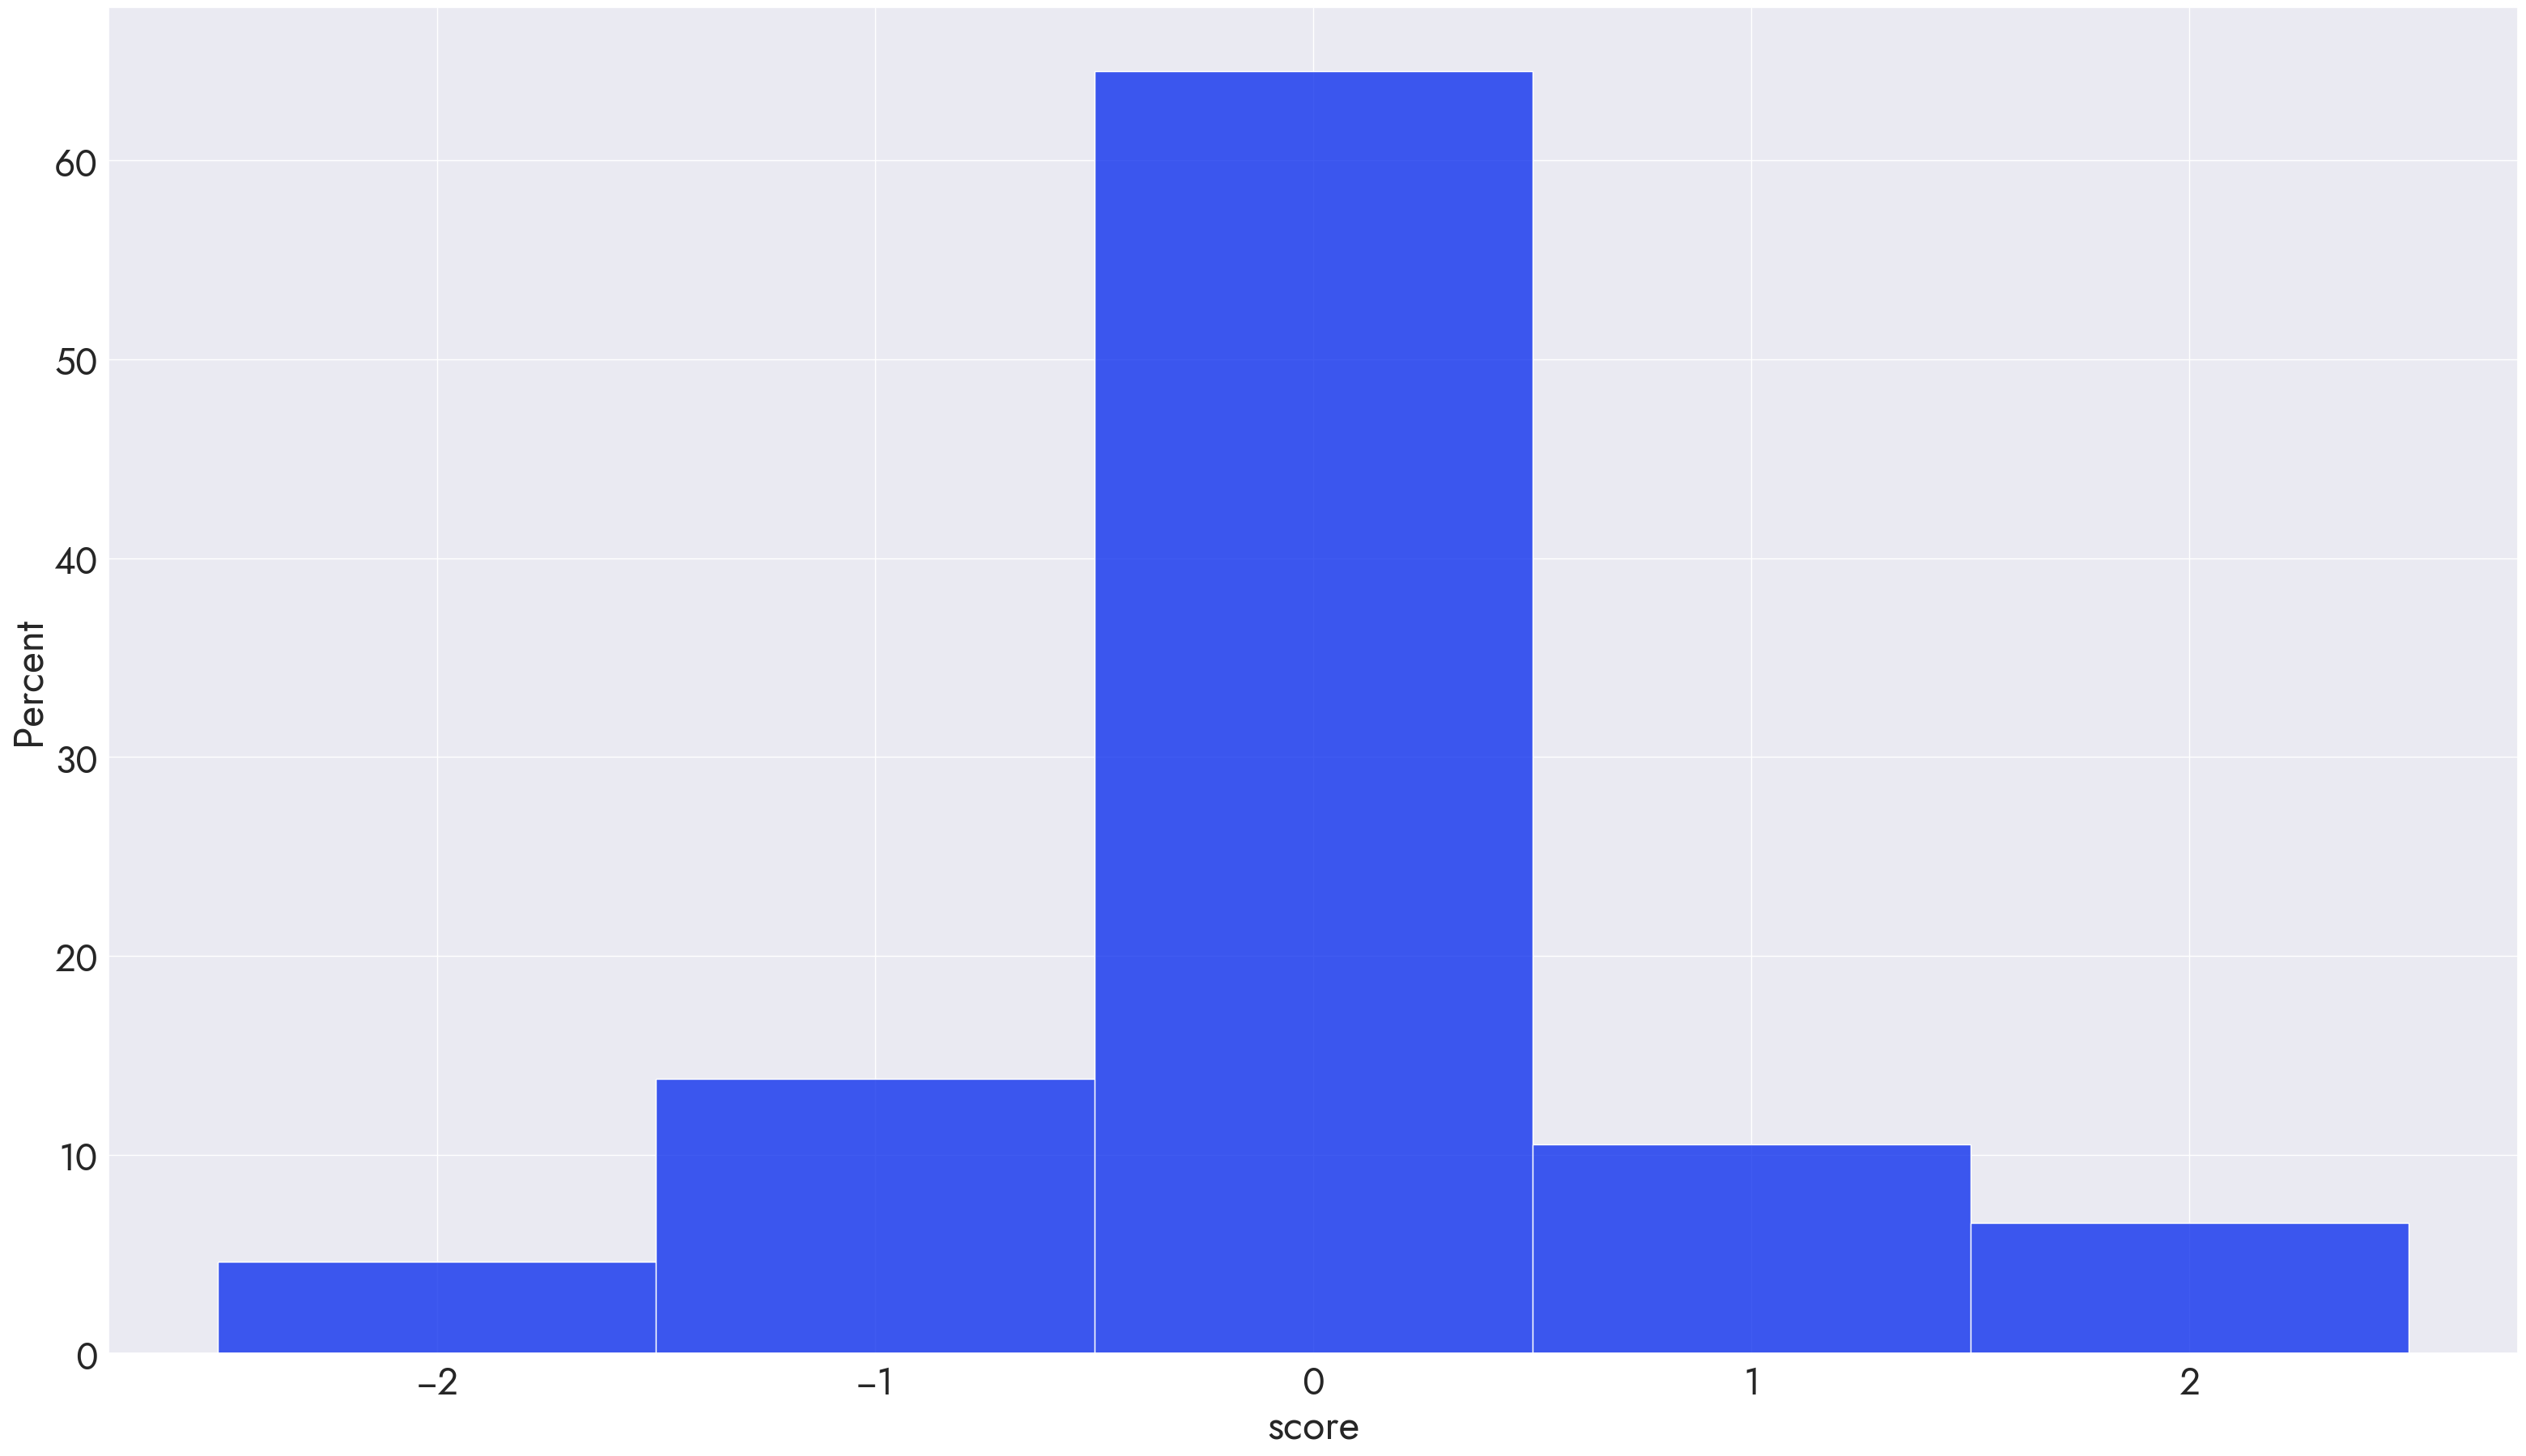

In [34]:
linear_plot_mistakes = sns.histplot(data=test_predict - test_target,
                                    stat='percent', legend=False, discrete=True)

linear_plot_mistakes.set_xlabel('mistake')
linear_plot_mistakes.set_xlabel('score');

In [35]:
linear_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_mistakes_linear.png', transparent=True)

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп.
Однако все модели имеют тенденцию к переобучению - их точность на обучающем наборе значительно выше, чем на тестовом.

## Setting
В дальнейшем предполагается построение нескольких моделей, различающихся по крупности.
Напишем общую функцию их настройки и обучения:
* optimizer - формула, по которой происходит оптимизация модели
* loss - формула, по которой рассчитываются ошибки предсказаний модели
* batch_size - размер совокупности наблюдений, по которым модель обучается за раз
* callbacks - дополнительные параметры, в данном случае отвечающие за остановку обучения в случае минимальных изменений от эпохи, а также за запись процесса обучения

In [16]:
def compile_and_fit(model: tf.keras.Sequential, max_epochs: int = 1000, patience: int = 5):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[
            tf.keras.metrics.CategoricalAccuracy(name='accuracy')
        ],
    )

    model.summary()

    history = model.fit(
        train_features, train_target,
        batch_size=BATCH_SIZE,
        validation_split=0.2,  # 20% of train data will validate model
        epochs=max_epochs,  # number model loops
        verbose=2,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1, start_from_epoch=10, restore_best_weights=True),
            tf.keras.callbacks.TensorBoard(f'{LOGS_PATH}/{SERIAL_TYPE}_{model.name}'),
        ],
    )

    return history.history

Для обучения моделей целевой показатель должен представлять собой dummy-переменную.
Переведём их:

In [17]:
train_target = tf.keras.utils.to_categorical(train_target, dtype='int8')
test_target = tf.keras.utils.to_categorical(test_target, dtype='int8')

Из ноутбука с визуализацией было выяснено, что признаки имеют выраженное левостороннее распределение.
Создадим слой для их нормализации:

In [18]:
normalize = tf.keras.layers.Normalization()
normalize.adapt(train_features, batch_size=BATCH_SIZE)

2023-05-31 19:30:38.514288: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:30:38.528184: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:30:38.528242: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:30:38.531050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:30:38.531164: I tensorflow/compile

Создадим переменную, в которой будут сохраняться логи обучения моделей и их проверка на тестовом наборе:

In [19]:
train_histories = {}
test_results = {}

## Deep neural networks
Построим модели глубоких нейронных сетей (DNN).

### tiny
Обучим модель, состоящую из двух обучающих слоёв.

In [20]:
tiny_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(16, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='tiny'
)

In [21]:
train_histories[tiny_model.name] = compile_and_fit(tiny_model)

Model: "tiny"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense (Dense)               (None, 16)                224       
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 319
Trainable params: 292
Non-trainable params: 27
_________________________________________________________________
Epoch 1/1000


2023-05-31 19:30:41.344054: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5589bfe64f10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-31 19:30:41.344124: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2023-05-31 19:30:41.349891: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-31 19:30:42.954687: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-05-31 19:30:43.050304: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-31 19:30:43.120288: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 - 4s - loss: 1.6358 - accuracy: 0.2247 - val_loss: 1.6052 - val_accuracy: 0.2459 - 4s/epoch - 229ms/step
Epoch 2/1000
16/16 - 0s - loss: 1.5268 - accuracy: 0.2309 - val_loss: 1.5177 - val_accuracy: 0.2541 - 113ms/epoch - 7ms/step
Epoch 3/1000
16/16 - 0s - loss: 1.4440 - accuracy: 0.2454 - val_loss: 1.4443 - val_accuracy: 0.2459 - 120ms/epoch - 8ms/step
Epoch 4/1000
16/16 - 0s - loss: 1.3777 - accuracy: 0.2660 - val_loss: 1.3810 - val_accuracy: 0.2377 - 119ms/epoch - 7ms/step
Epoch 5/1000
16/16 - 0s - loss: 1.3210 - accuracy: 0.2928 - val_loss: 1.3236 - val_accuracy: 0.3115 - 111ms/epoch - 7ms/step
Epoch 6/1000
16/16 - 0s - loss: 1.2701 - accuracy: 0.3753 - val_loss: 1.2724 - val_accuracy: 0.3770 - 118ms/epoch - 7ms/step
Epoch 7/1000
16/16 - 0s - loss: 1.2269 - accuracy: 0.4557 - val_loss: 1.2280 - val_accuracy: 0.4836 - 113ms/epoch - 7ms/step
Epoch 8/1000
16/16 - 0s - loss: 1.1873 - accuracy: 0.5052 - val_loss: 1.1870 - val_accuracy: 0.4918 - 107ms/epoch - 7ms/step
Epoch 9/1000
1

Визуализируем ход обучения:

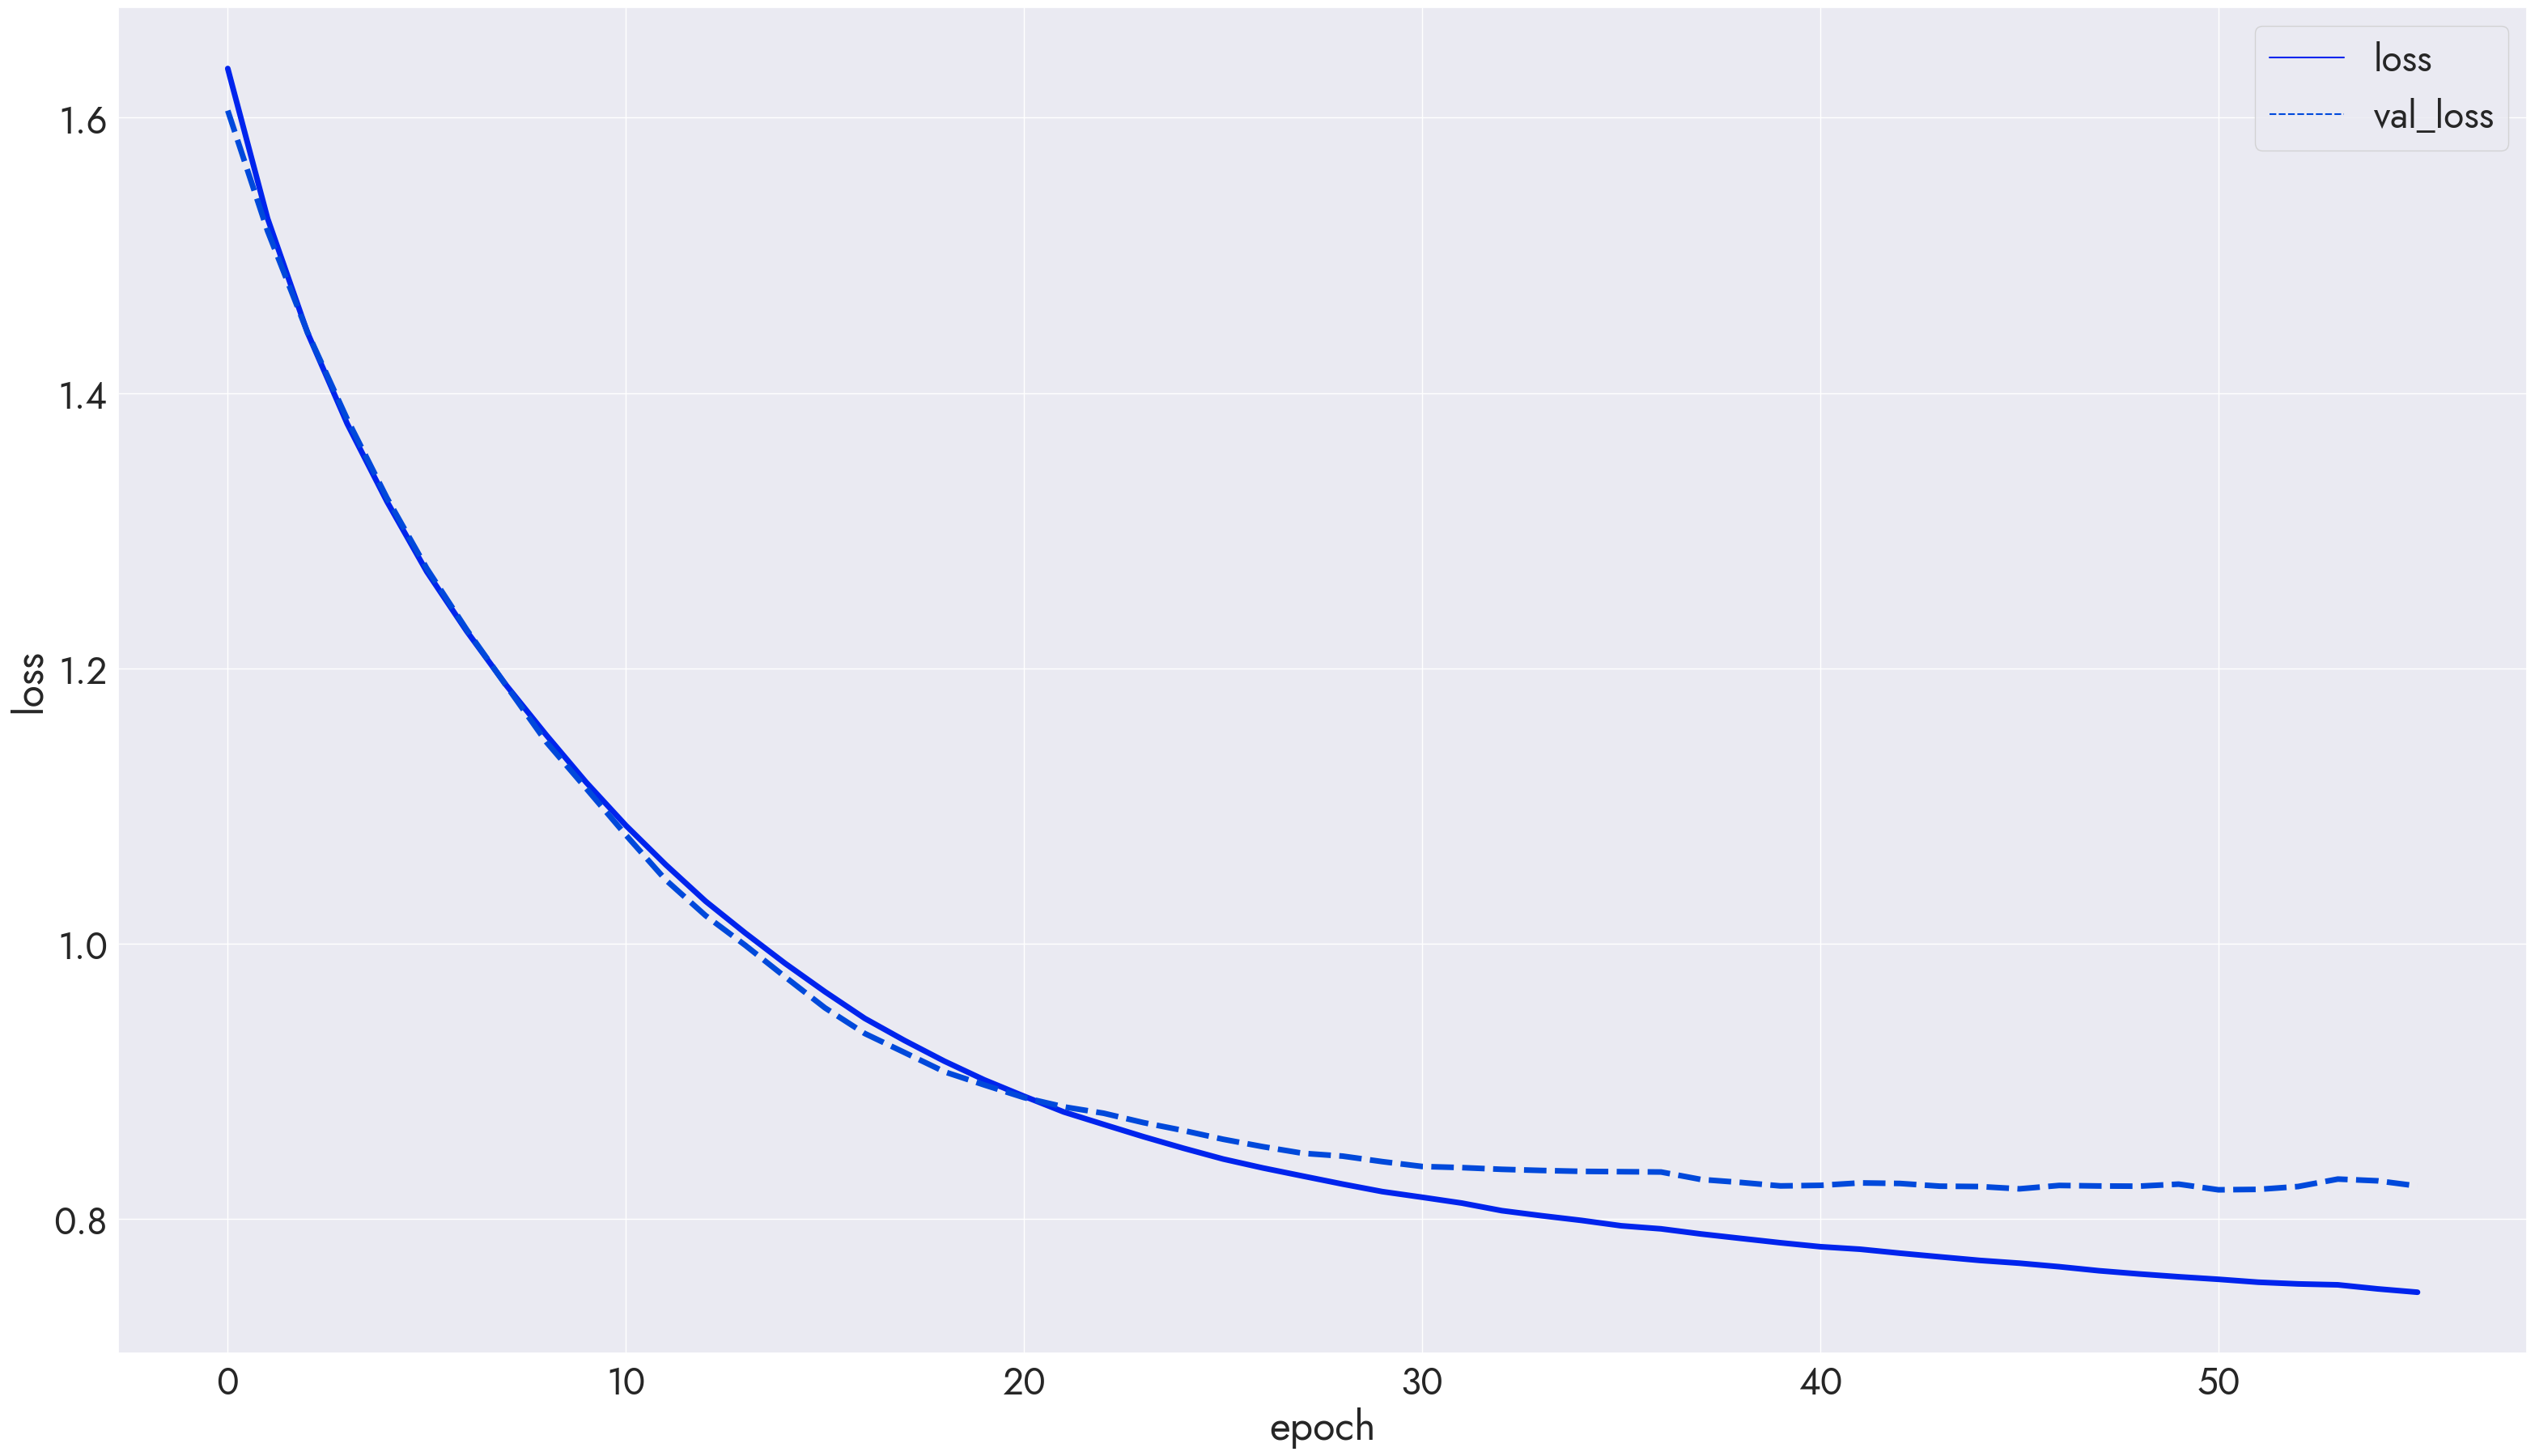

In [22]:
tiny_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[tiny_model.name])[['loss', 'val_loss']], linewidth=5)

tiny_plot_history.set_xlabel('epoch')
tiny_plot_history.set_ylabel('loss');

In [23]:
tiny_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{tiny_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [24]:
tiny_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.7668 - accuracy: 0.6639 - 196ms/epoch - 10ms/step


In [25]:
test_results[tiny_model.name] = tiny_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 0.9146 - accuracy: 0.5789 - 39ms/epoch - 8ms/step


Сохраним обученную модель:

In [26]:
tiny_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{tiny_model.name}')

INFO:tensorflow:Assets written to: model/light/mobile/mobile_tiny/assets


2023-05-31 19:30:53 - tensorflow - INFO - Assets written to: model/light/mobile/mobile_tiny/assets


### small
Обучим модель, состоящую из трёх обучающих слоёв.

In [27]:
small_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(32, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(32, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='small'
)

In [28]:
train_histories[small_model.name] = compile_and_fit(small_model)

Model: "small"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_2 (Dense)             (None, 32)                448       
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 1,663
Trainable params: 1,636
Non-trainable params: 27
_________________________________________________________________
Epoch 1/1000
16/16 - 1s - loss: 1.4166 - accuracy: 0.3237 - val_loss: 1.4175 - val_accuracy: 0.2623 - 1s/epoch - 86ms/step
E

Визуализируем ход обучения:

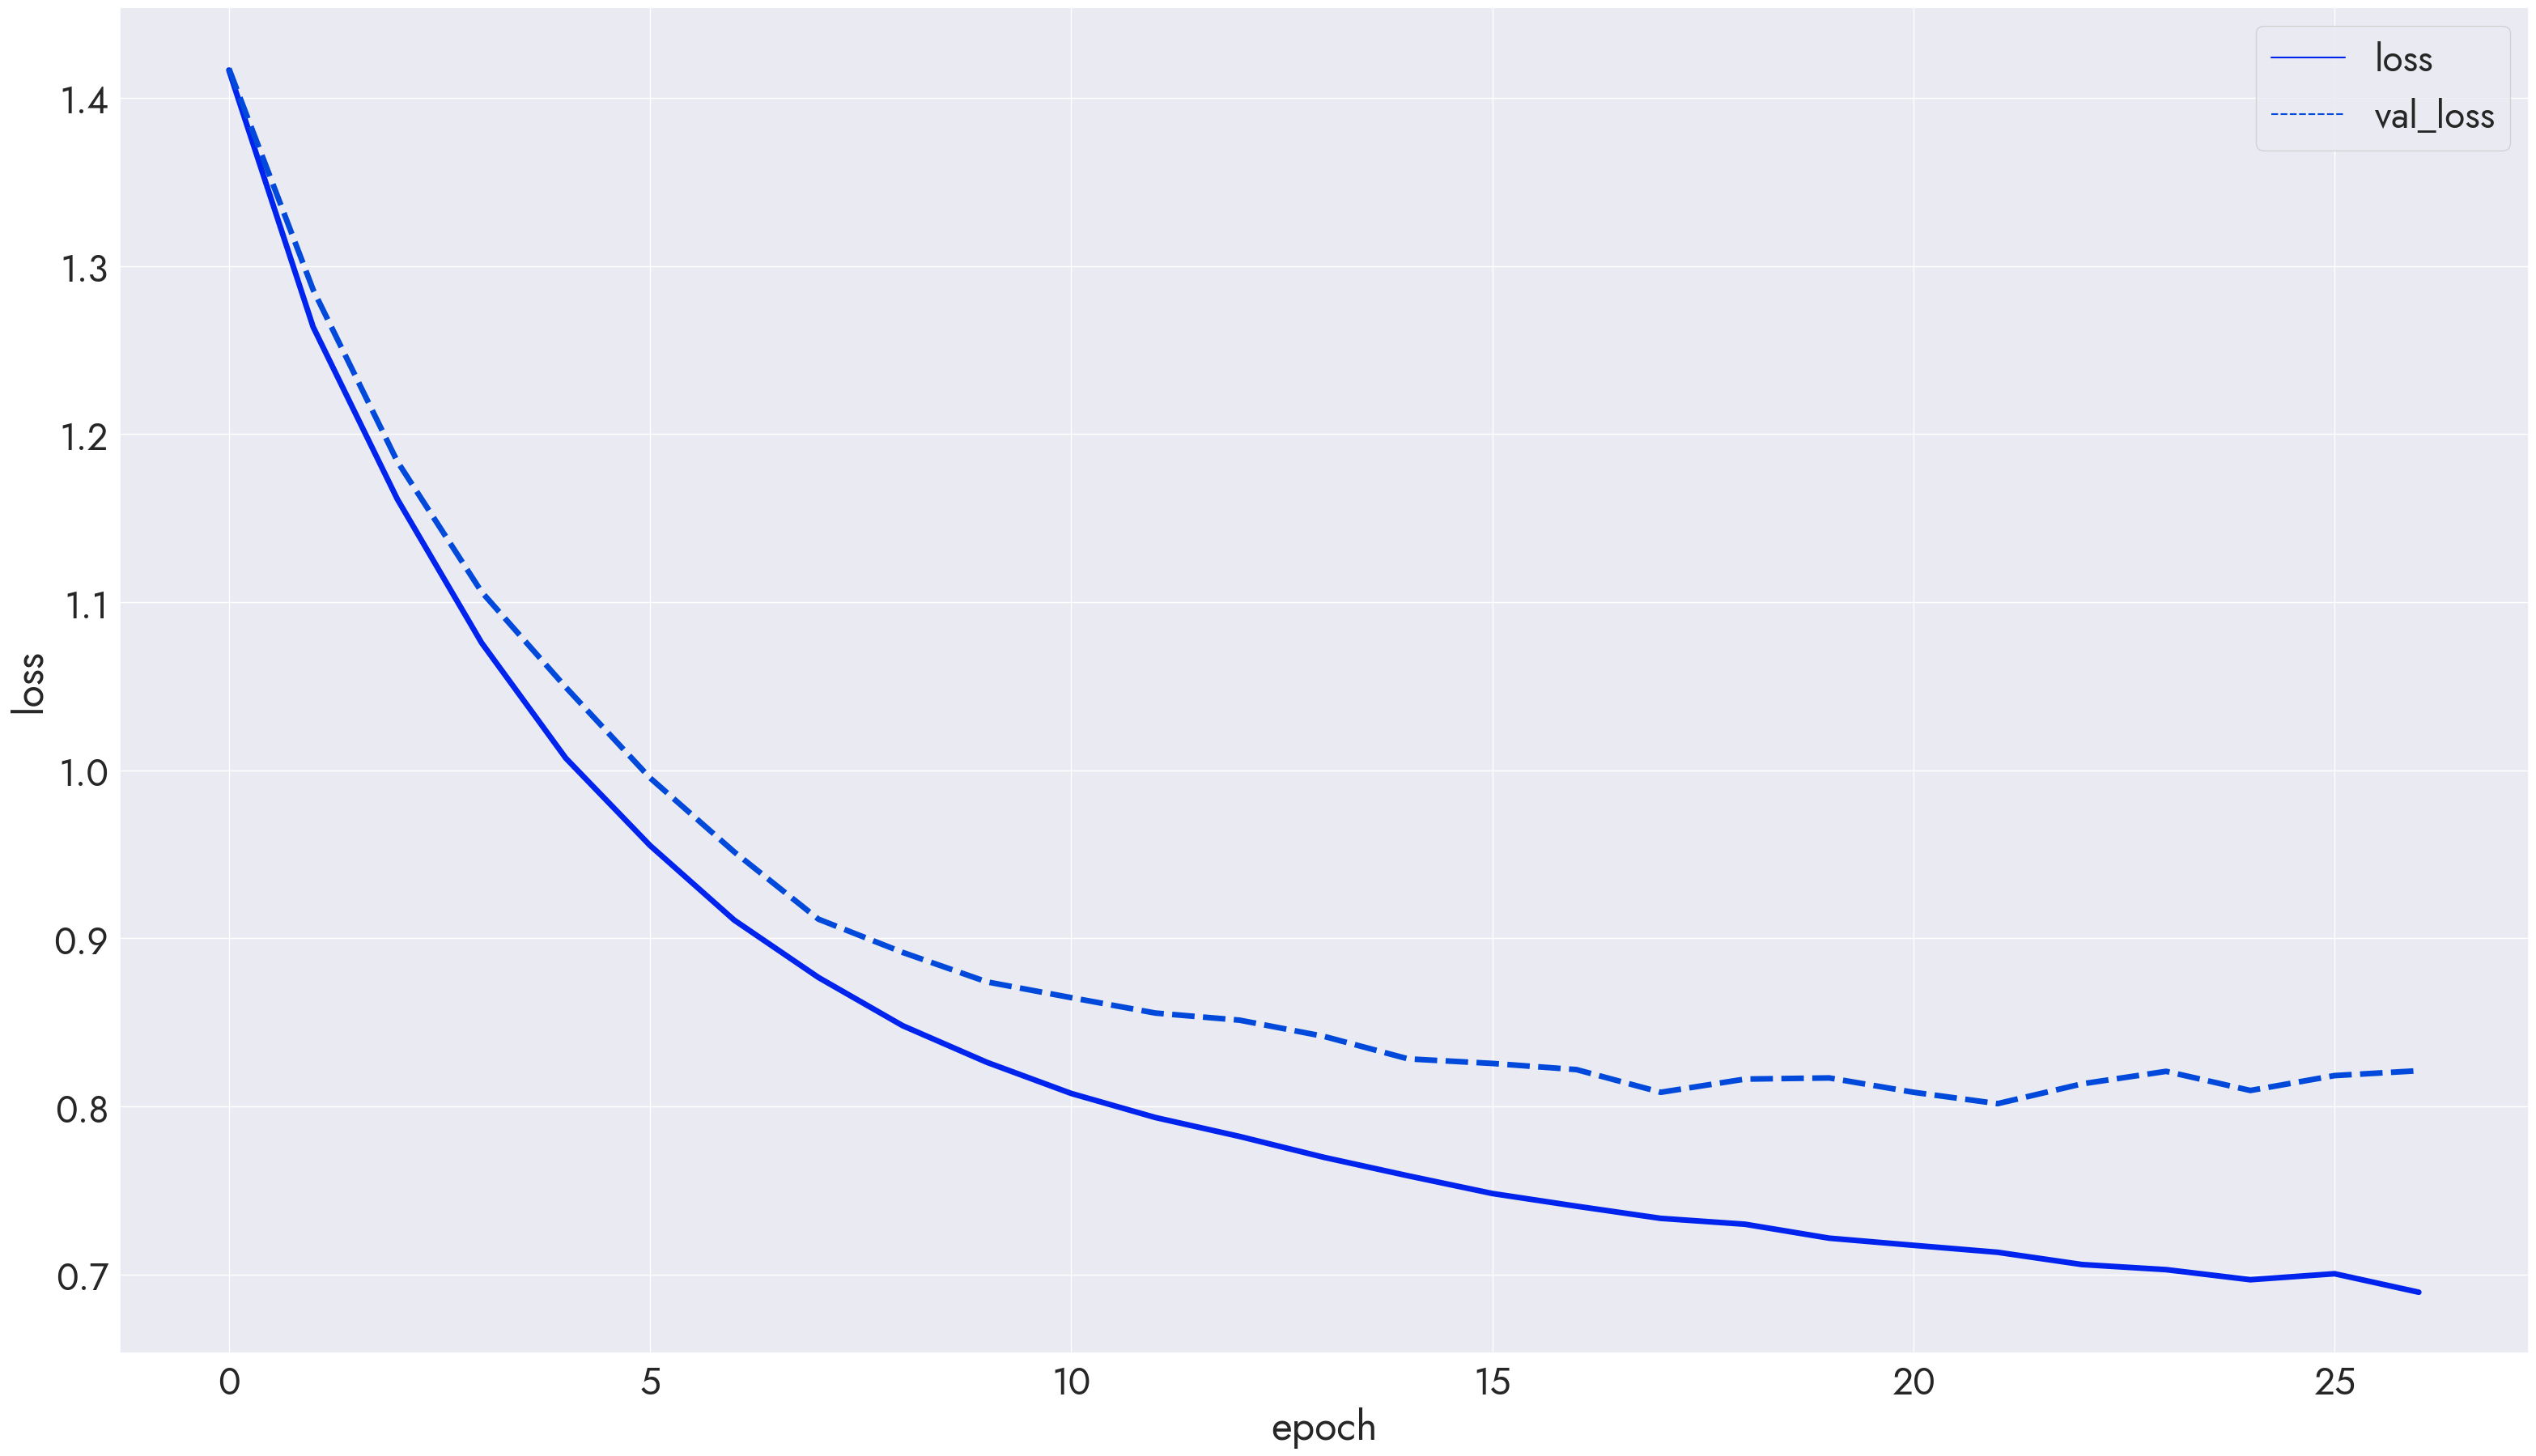

In [29]:
small_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[small_model.name])[['loss', 'val_loss']], linewidth=5)

small_plot_history.set_xlabel('epoch')
small_plot_history.set_ylabel('loss');

In [30]:
small_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{small_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [31]:
small_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.7244 - accuracy: 0.6837 - 119ms/epoch - 6ms/step


In [32]:
test_results[small_model.name] = small_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 0.9047 - accuracy: 0.6053 - 50ms/epoch - 10ms/step


Сохраним модель:

In [33]:
small_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{small_model.name}')

INFO:tensorflow:Assets written to: model/light/mobile/mobile_small/assets


2023-05-31 19:31:01 - tensorflow - INFO - Assets written to: model/light/mobile/mobile_small/assets


### medium
Обучим модель, состоящую из трёх обучающих слоёв.

In [34]:
medium_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='medium'
)

In [35]:
train_histories[medium_model.name] = compile_and_fit(medium_model)

Model: "medium"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                896       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 260       
                                                                 
Total params: 5,343
Trainable params: 5,316
Non-trainable params: 27
_________________________________________________________

Визуализируем ход обучения:

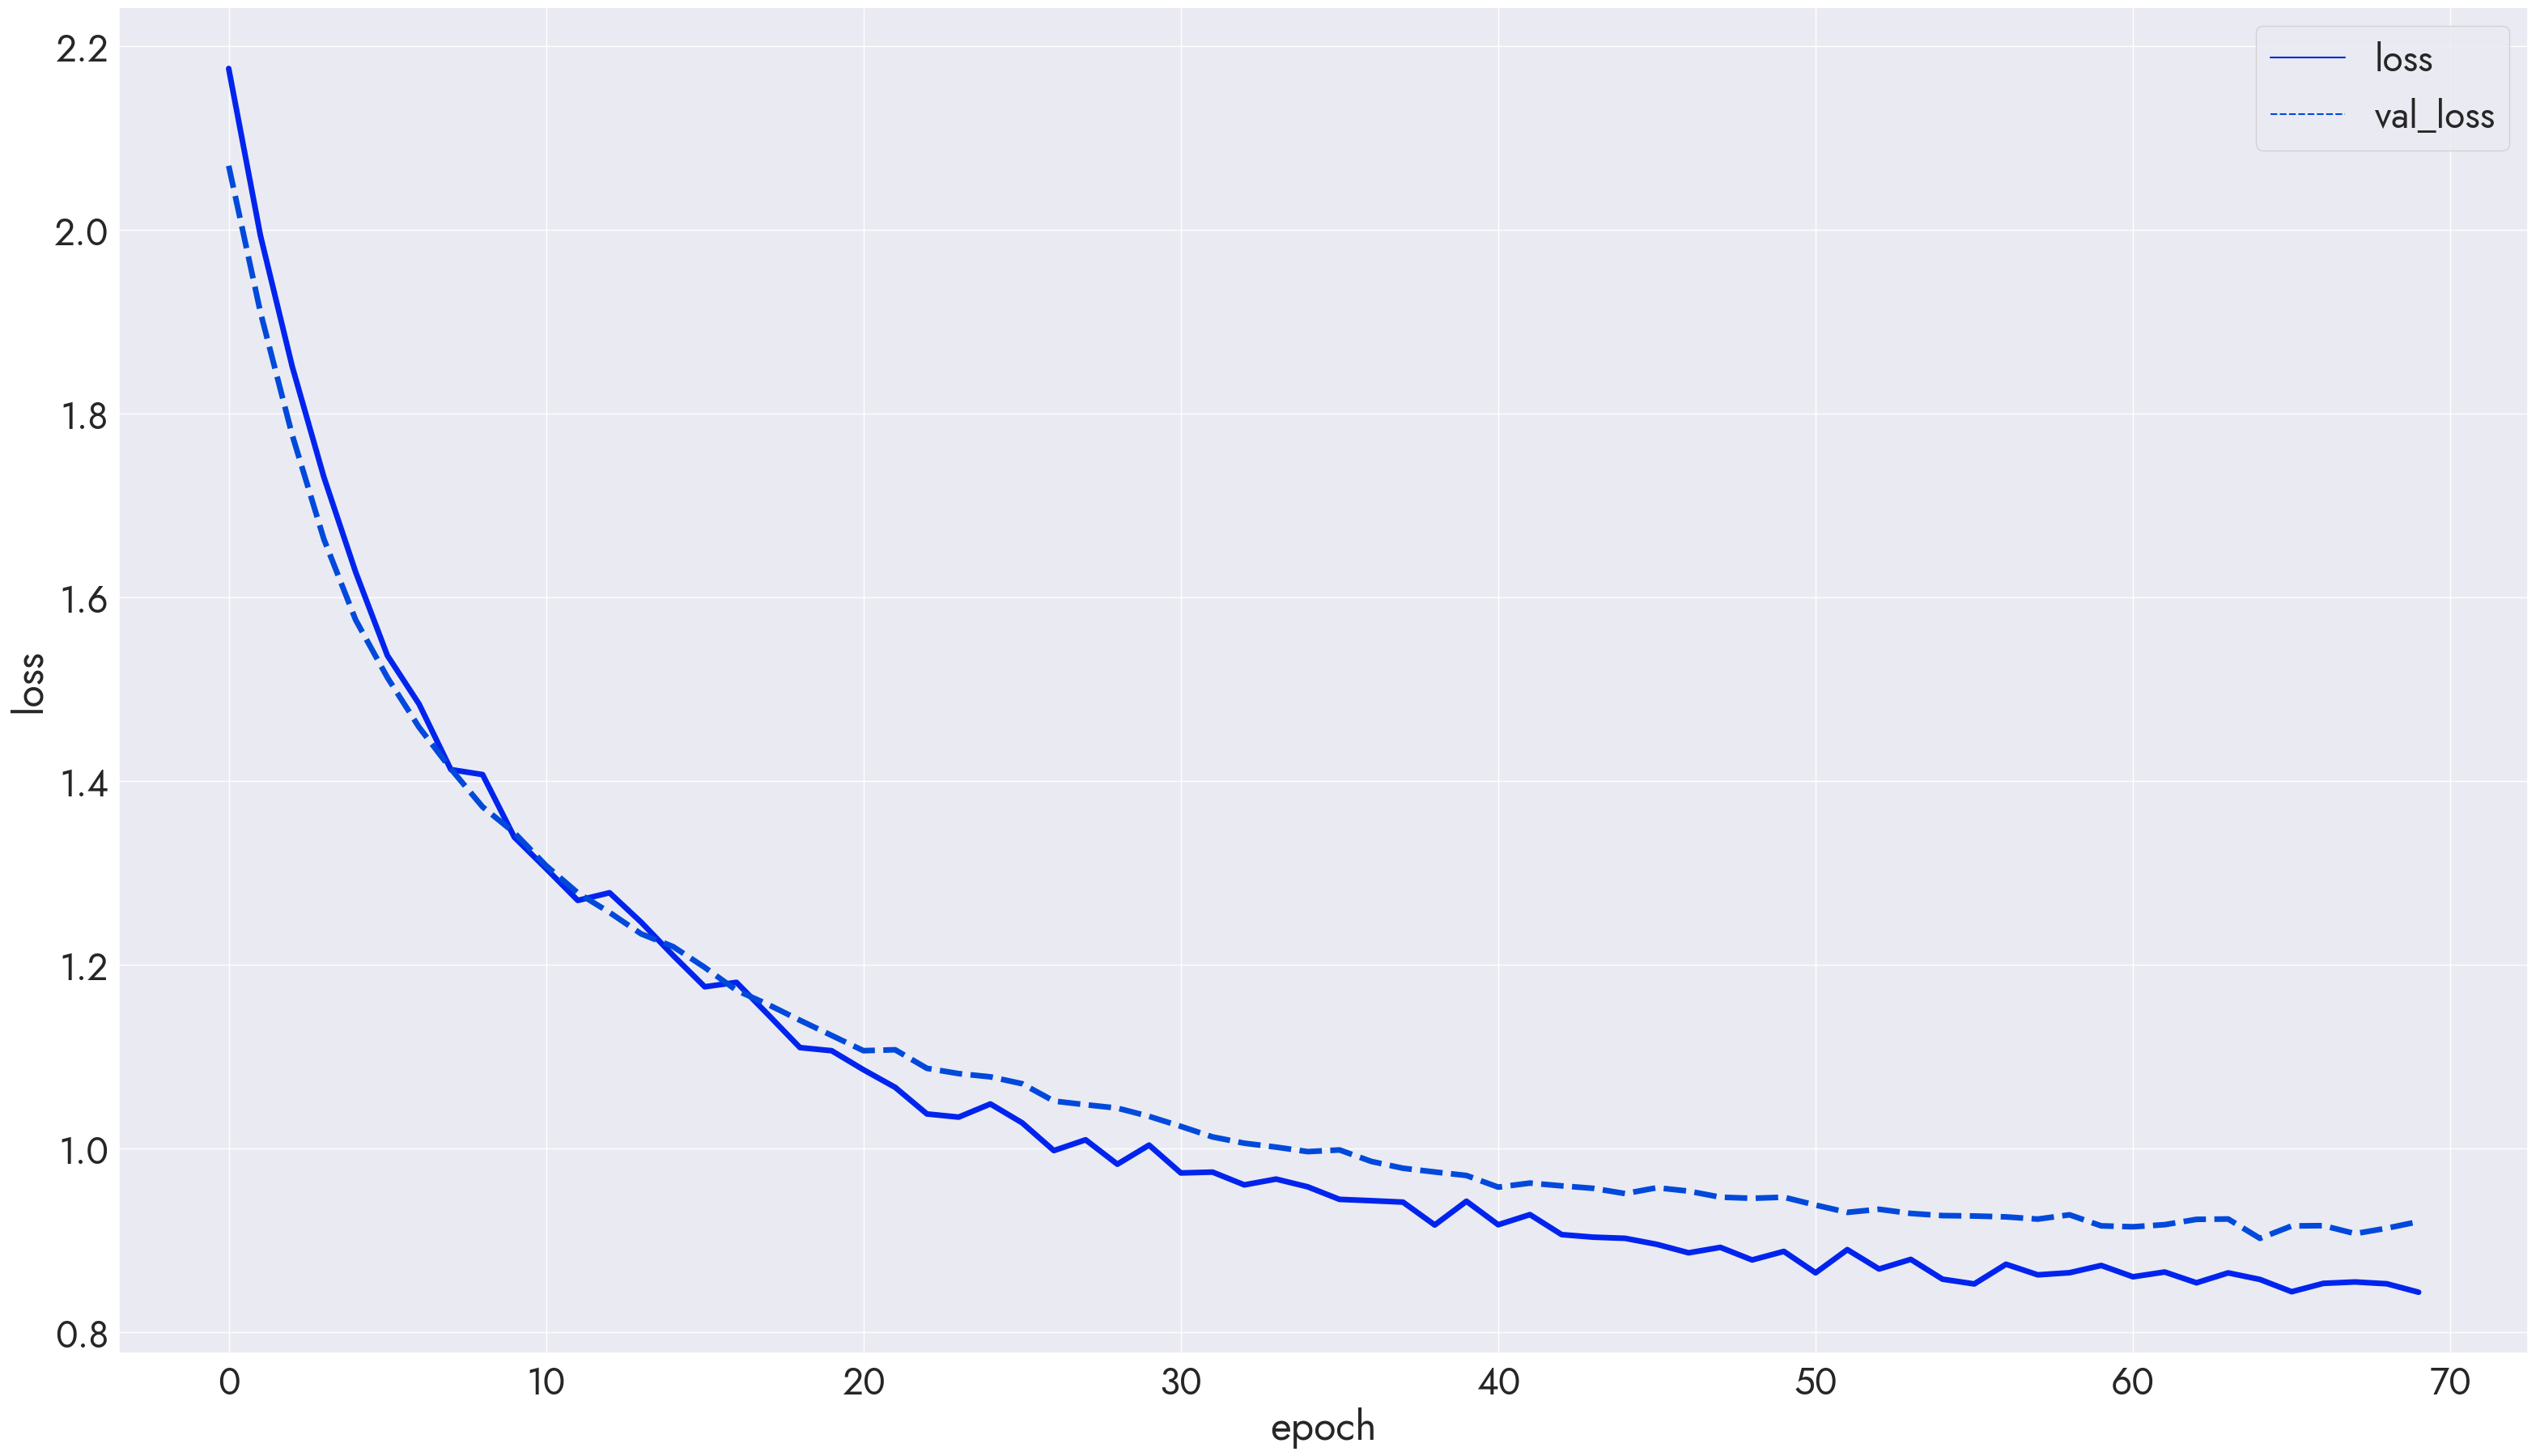

In [36]:
medium_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[medium_model.name])[['loss', 'val_loss']], linewidth=5)

medium_plot_history.set_xlabel('epoch')
medium_plot_history.set_ylabel('loss');

In [37]:
medium_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{medium_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [38]:
medium_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.8305 - accuracy: 0.6886 - 113ms/epoch - 6ms/step


In [39]:
test_results[medium_model.name] = medium_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 1.0095 - accuracy: 0.5987 - 63ms/epoch - 13ms/step


Сохраним модель:

In [40]:
medium_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{medium_model.name}')

2023-05-31 19:31:15.156472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-31 19:31:15.327332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/light/mobile/mobile_medium/assets


2023-05-31 19:31:15 - tensorflow - INFO - Assets written to: model/light/mobile/mobile_medium/assets


### large
Обучим модель, состоящую из шести обучающих слоёв.

In [41]:
large_model = tf.keras.Sequential(
    [
        normalize,
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(), activation=tf.keras.activations.relu),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation=tf.keras.activations.relu),
        tf.keras.layers.Dense(train_target.shape[1], activation=tf.keras.activations.softmax),
    ],
    name='large'
)

In [42]:
train_histories[large_model.name] = compile_and_fit(large_model)

Model: "large"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 13)               27        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 256)               3584      
                                                                 
 dense_9 (Dense)             (None, 256)               65792     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                             

Визуализируем ход обучения:

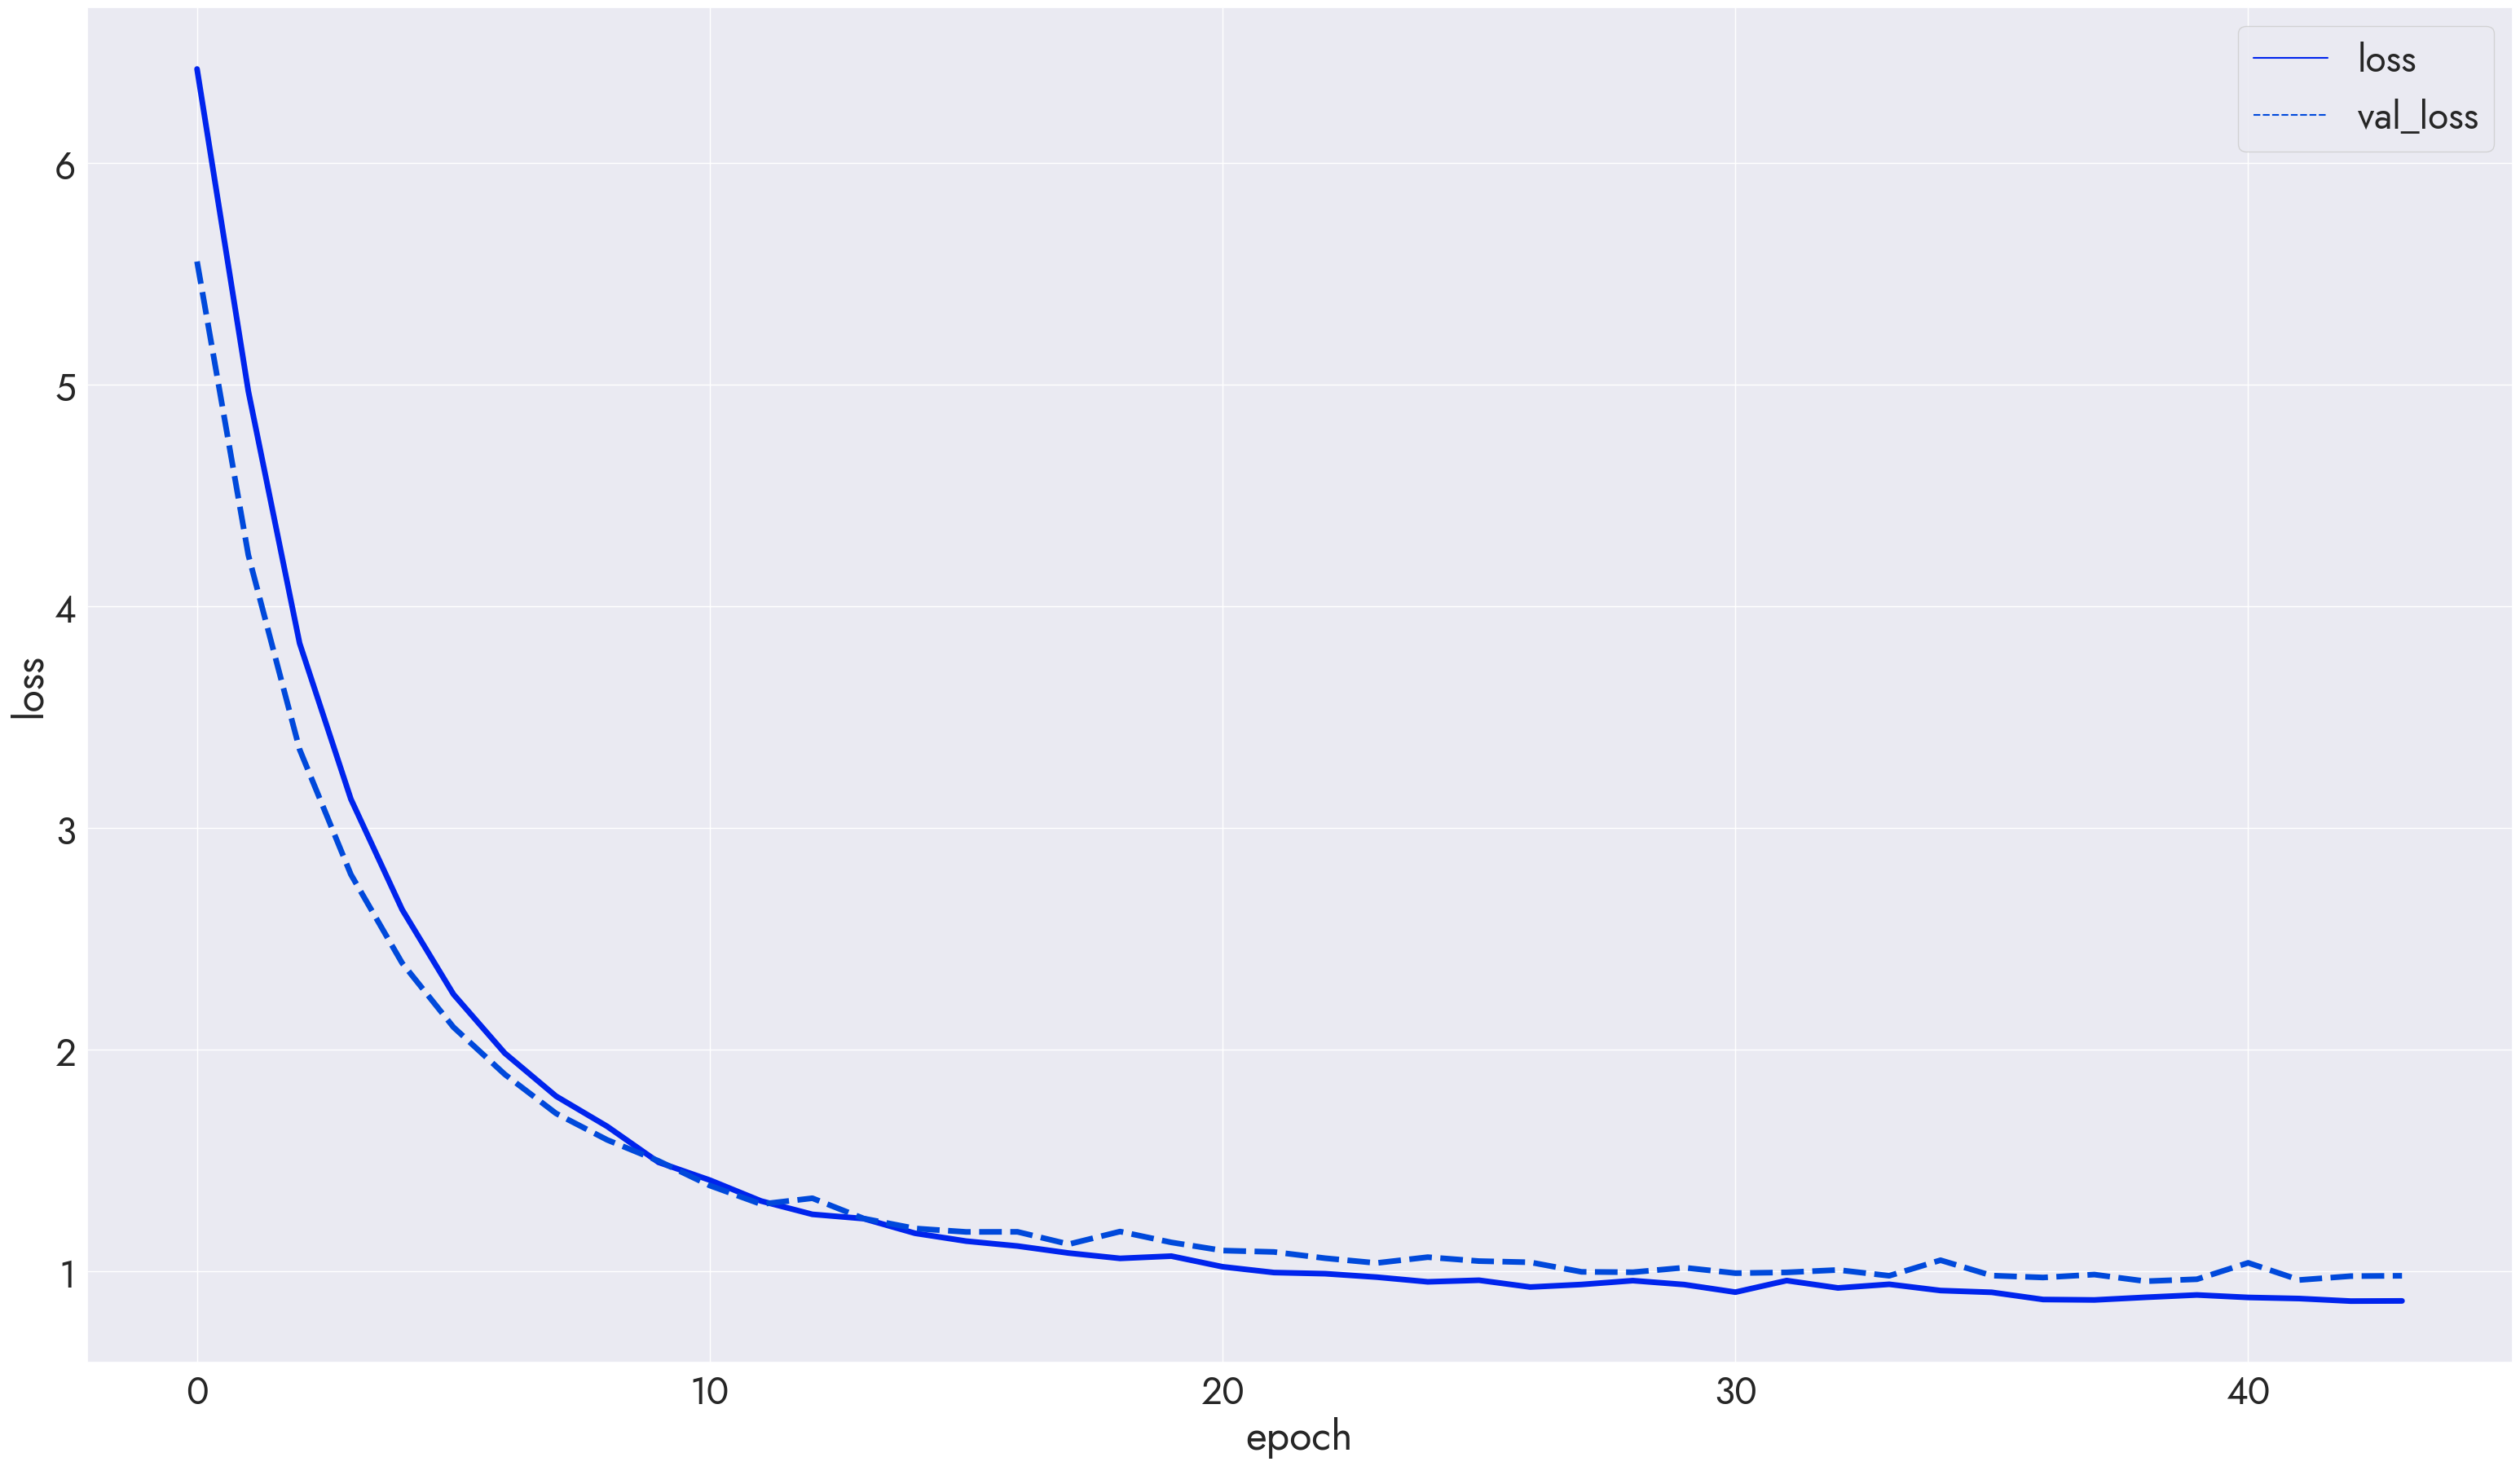

In [43]:
large_plot_history = sns.lineplot(data=pd.DataFrame(train_histories[large_model.name])[['loss', 'val_loss']], linewidth=5)

large_plot_history.set_xlabel('epoch')
large_plot_history.set_ylabel('loss');

In [44]:
large_plot_history.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_{large_model.name}.png', transparent=True)

Посмотрим предсказательные возможности модели.

In [45]:
large_model.evaluate(train_features, train_target, batch_size=BATCH_SIZE, verbose=2);

19/19 - 0s - loss: 0.8855 - accuracy: 0.6936 - 122ms/epoch - 6ms/step


In [46]:
test_results[large_model.name] = large_model.evaluate(test_features, test_target, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - loss: 1.0611 - accuracy: 0.5921 - 46ms/epoch - 9ms/step


Сохраним модель:

In [47]:
large_model.save(f'{MODEL_PATH}/{SERIAL_TYPE}_{large_model.name}')

2023-05-31 19:31:27.837932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-31 19:31:27.858763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,128]
	 [[{{node inputs}}]]
2023-05-31 19:31:28.103968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256]
	 [[{{node inputs}}]]
2023-05-31 19:31

INFO:tensorflow:Assets written to: model/light/mobile/mobile_large/assets


2023-05-31 19:31:28 - tensorflow - INFO - Assets written to: model/light/mobile/mobile_large/assets


### finally
Выберем лучшую модель и проанализируем её предсказательные возможности.

Визуализируем график изменения точности предсказаний полученных моделей:

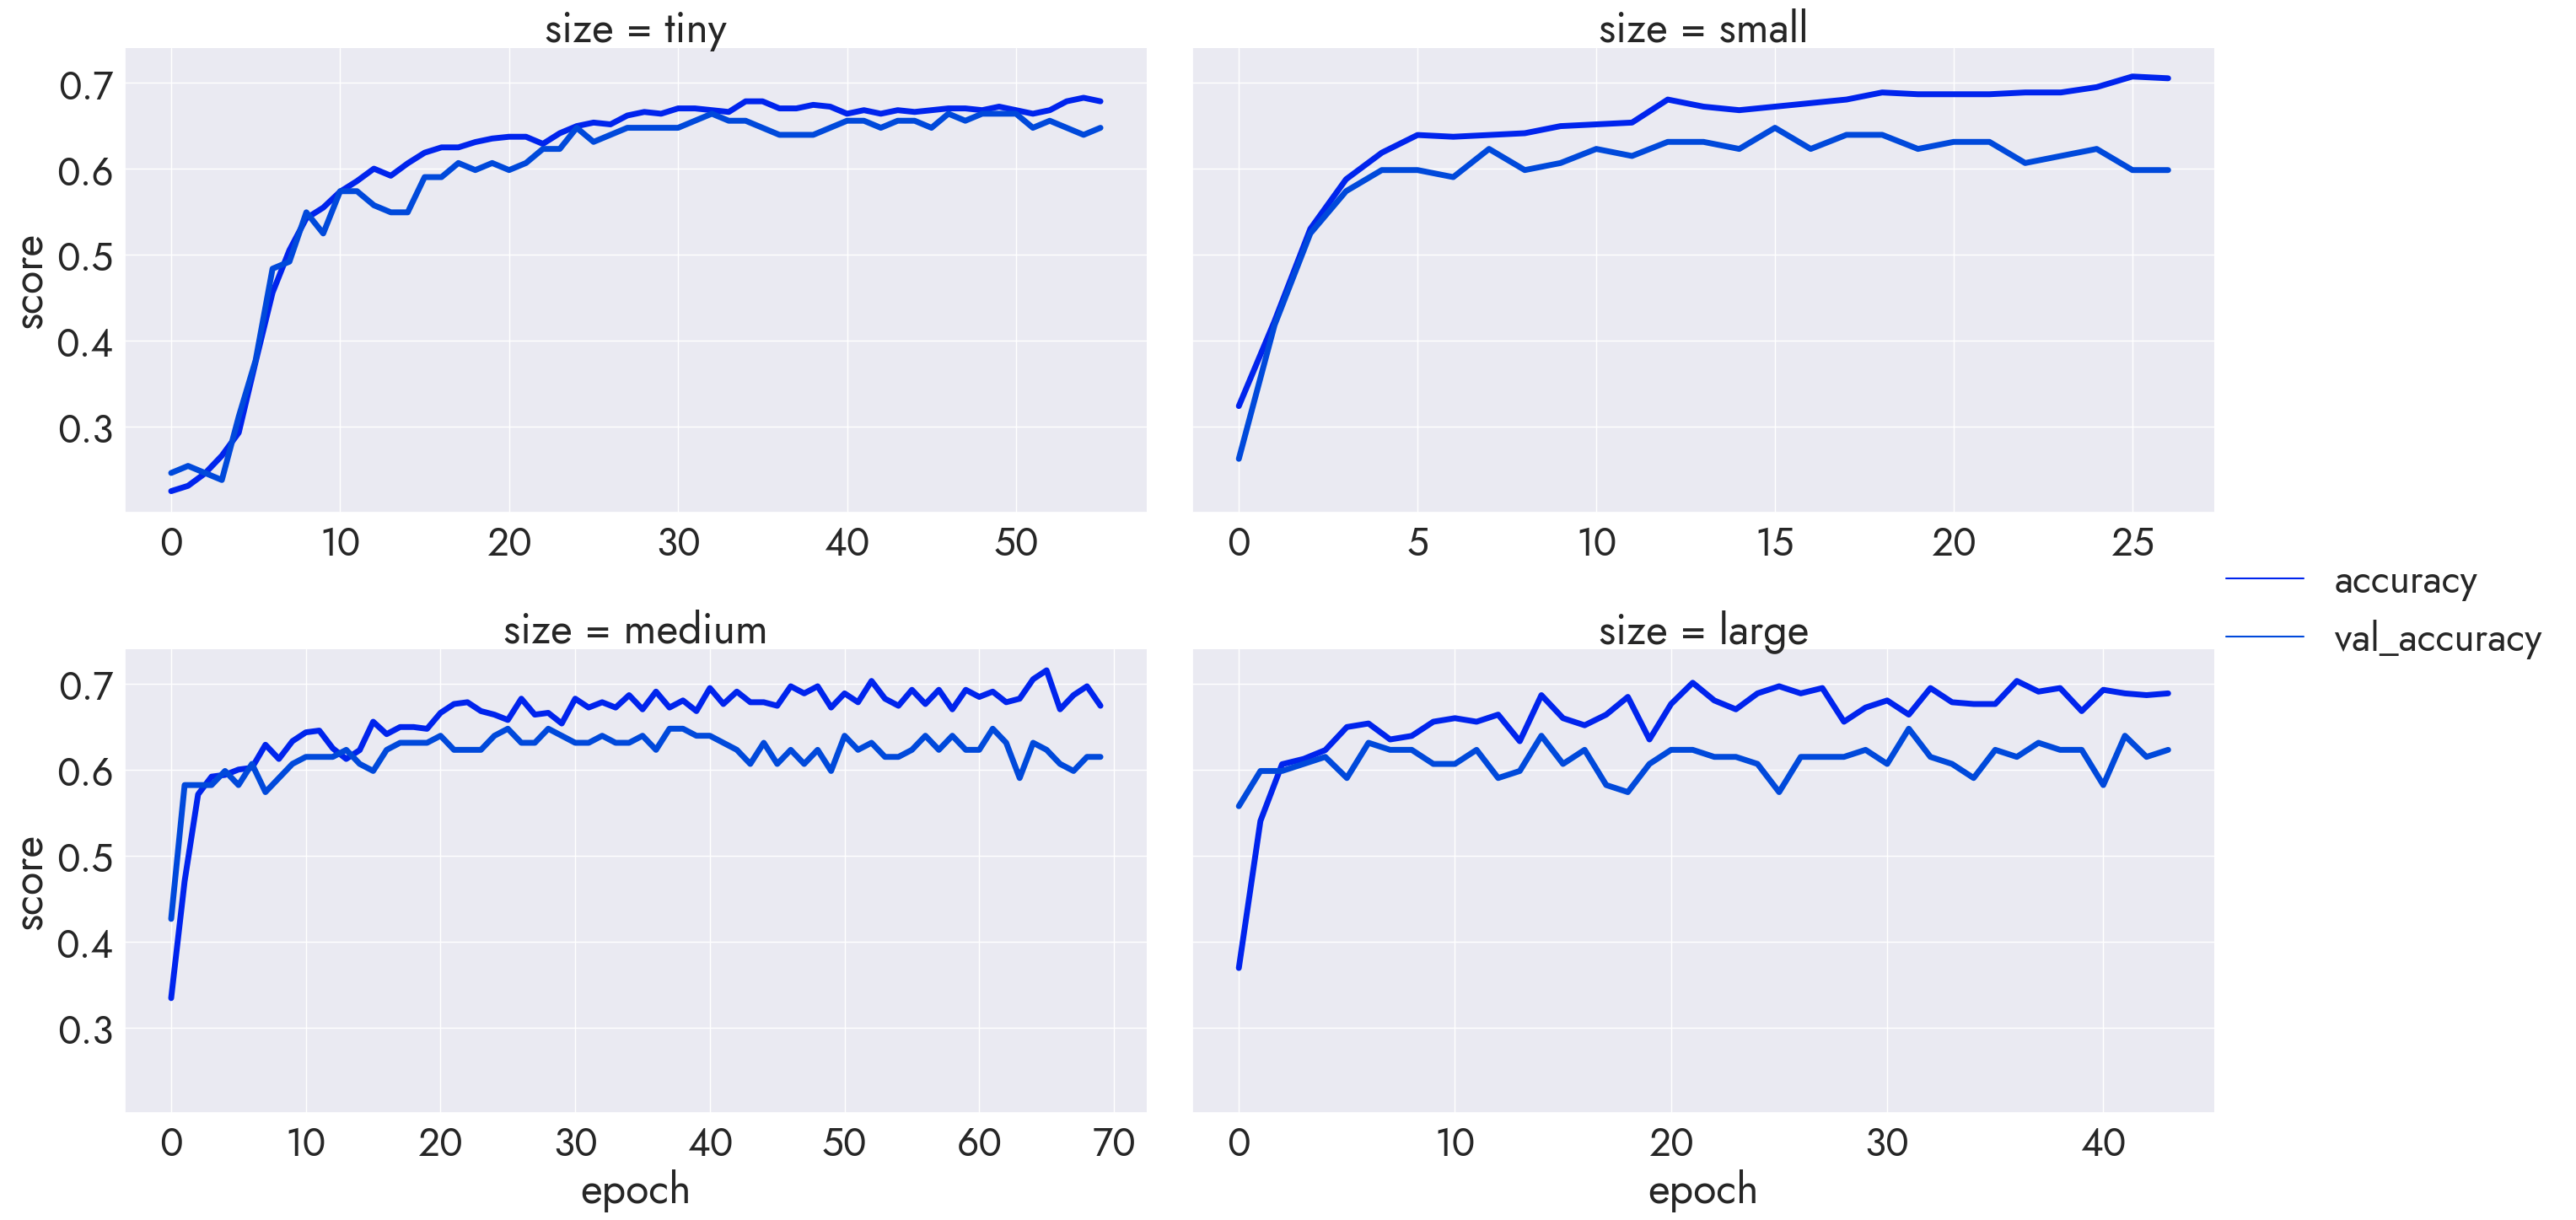

In [48]:
dnn_grid_history = sns.FacetGrid(
    data=(
        pd.concat(
            [pd.DataFrame(train_history)[['accuracy', 'val_accuracy']].stack() for train_history in train_histories.values()],
            keys=train_histories.keys(), names=['size', 'epoch', 'type'])
        .reset_index(level=['size'])
        .rename(columns={0: 'score'})
    ),
    col='size', col_wrap=2,
    height=FIG_SIZE[0] / 5, aspect=FIG_SIZE[0] / FIG_SIZE[1], sharex=False
)

dnn_grid_history.map_dataframe(sns.lineplot, 'epoch', 'score', hue='type', linewidth=5)
dnn_grid_history.add_legend();

In [49]:
dnn_grid_history.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_history_dnn.png', transparent=True)

Выберем в качестве основной модель с наибольшей точностью предсказаний:

In [50]:
dnn_model_results = pd.DataFrame(test_results, index=['test_loss', 'test_accuracy'])

dnn_model_results

,tiny,small,medium,large
test_loss,0.914644,0.904718,1.009501,1.061118
test_accuracy,0.578947,0.605263,0.598684,0.592105


In [51]:
dnn_model = small_model

С помощью данной модели предскажем результирующий показатель тестовой выборки:

In [52]:
test_predict = dnn_model.predict(test_features, batch_size=BATCH_SIZE, verbose=2);

5/5 - 0s - 87ms/epoch - 17ms/step


Массив предсказанных значений состоит из весов, с каким шансом к какой группе относится конкретное наблюдение.
Конвертируем его в вид dummy-переменных:

In [53]:
test_predict = np.where(test_predict == test_predict.max(axis=1).reshape(-1, 1), 1, 0)

Рассмотрим распределение предсказаний модели по группам:

In [54]:
from sklearn.metrics import confusion_matrix

dnn_dist = pd.DataFrame(confusion_matrix(test_df['group'], pd.from_dummies(pd.DataFrame(test_predict)).astype('int8')),
                        index=groups, columns=groups)
dnn_dist

,Low income,Lower-middle income,Upper-middle income,High income
Low income,33,5,0,0
Lower-middle income,16,14,4,5
Upper-middle income,7,9,15,9
High income,0,2,3,30


Выведем данную таблицу на тепловую карту:

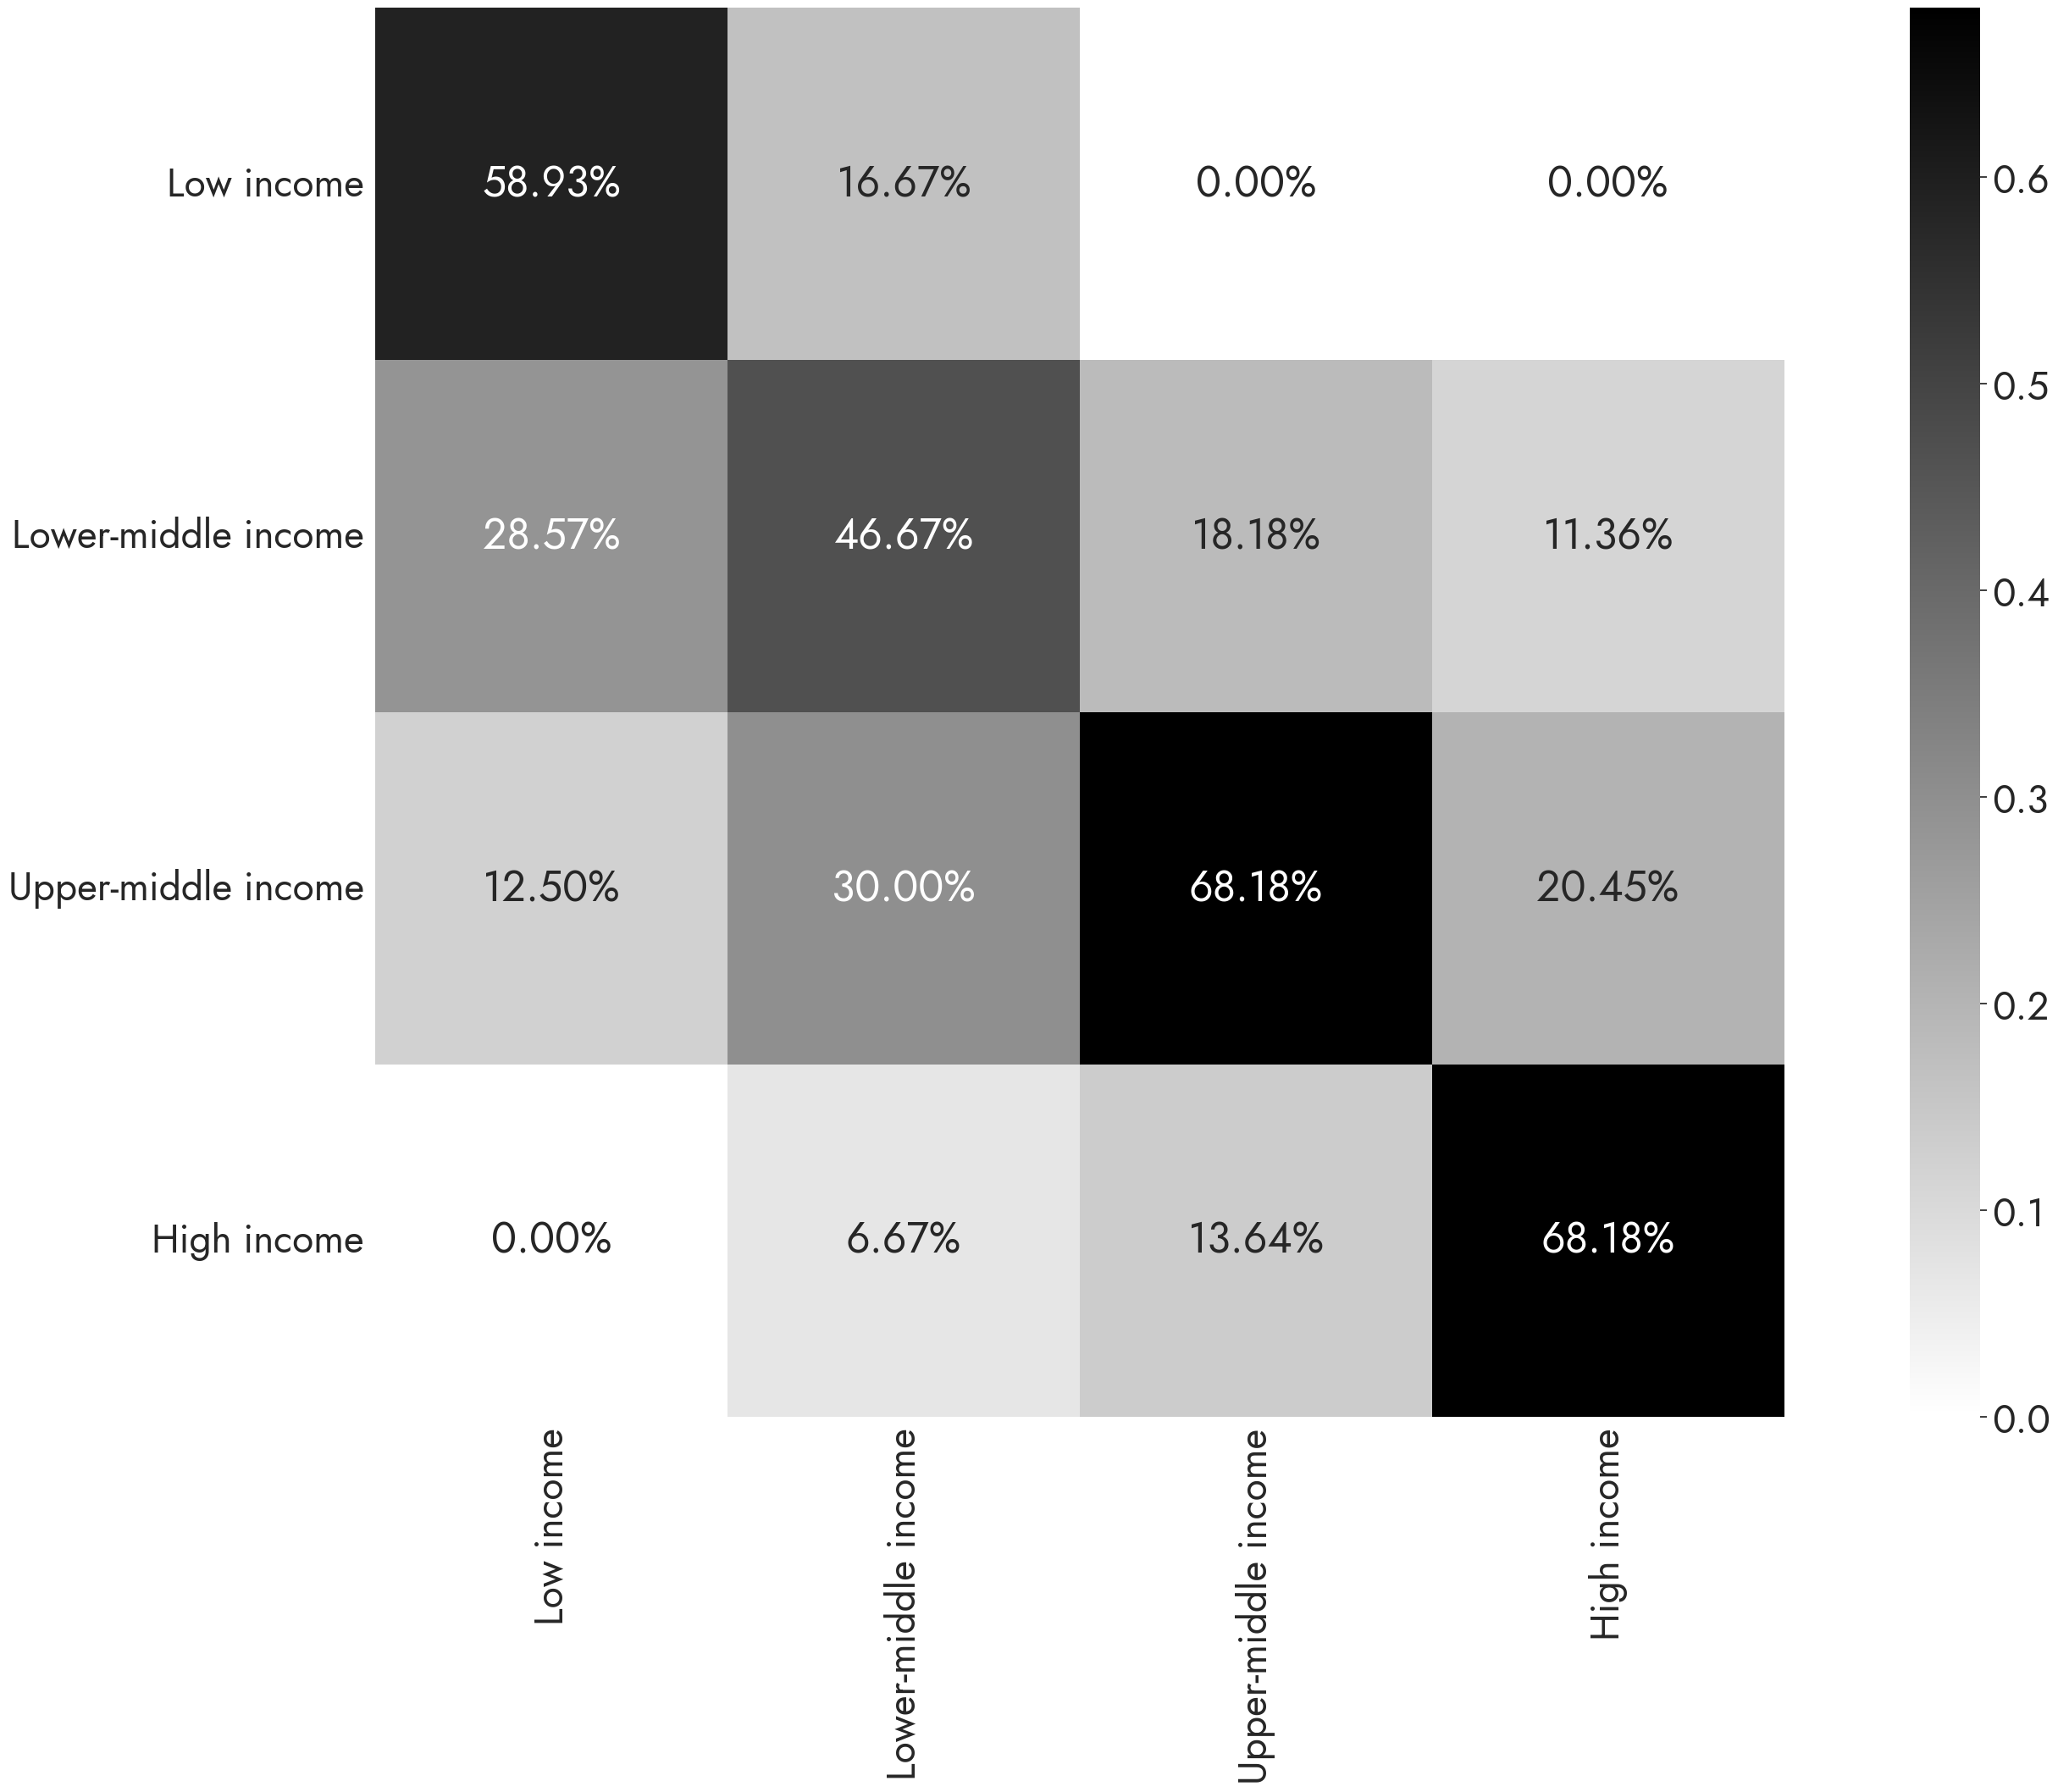

In [55]:
dnn_plot_dist = sns.heatmap(dnn_dist / dnn_dist.sum(), cmap='gray_r', annot=True, fmt='.2%', square=True)

dnn_plot_dist.set_xlabel(None);

In [56]:
dnn_plot_dist.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_dist_dnn.png', transparent=True)

Как видно по сводной таблице и по графику, в большинстве случаев модель верно определяет группу.
Визуализируем распределение ошибок в модели:

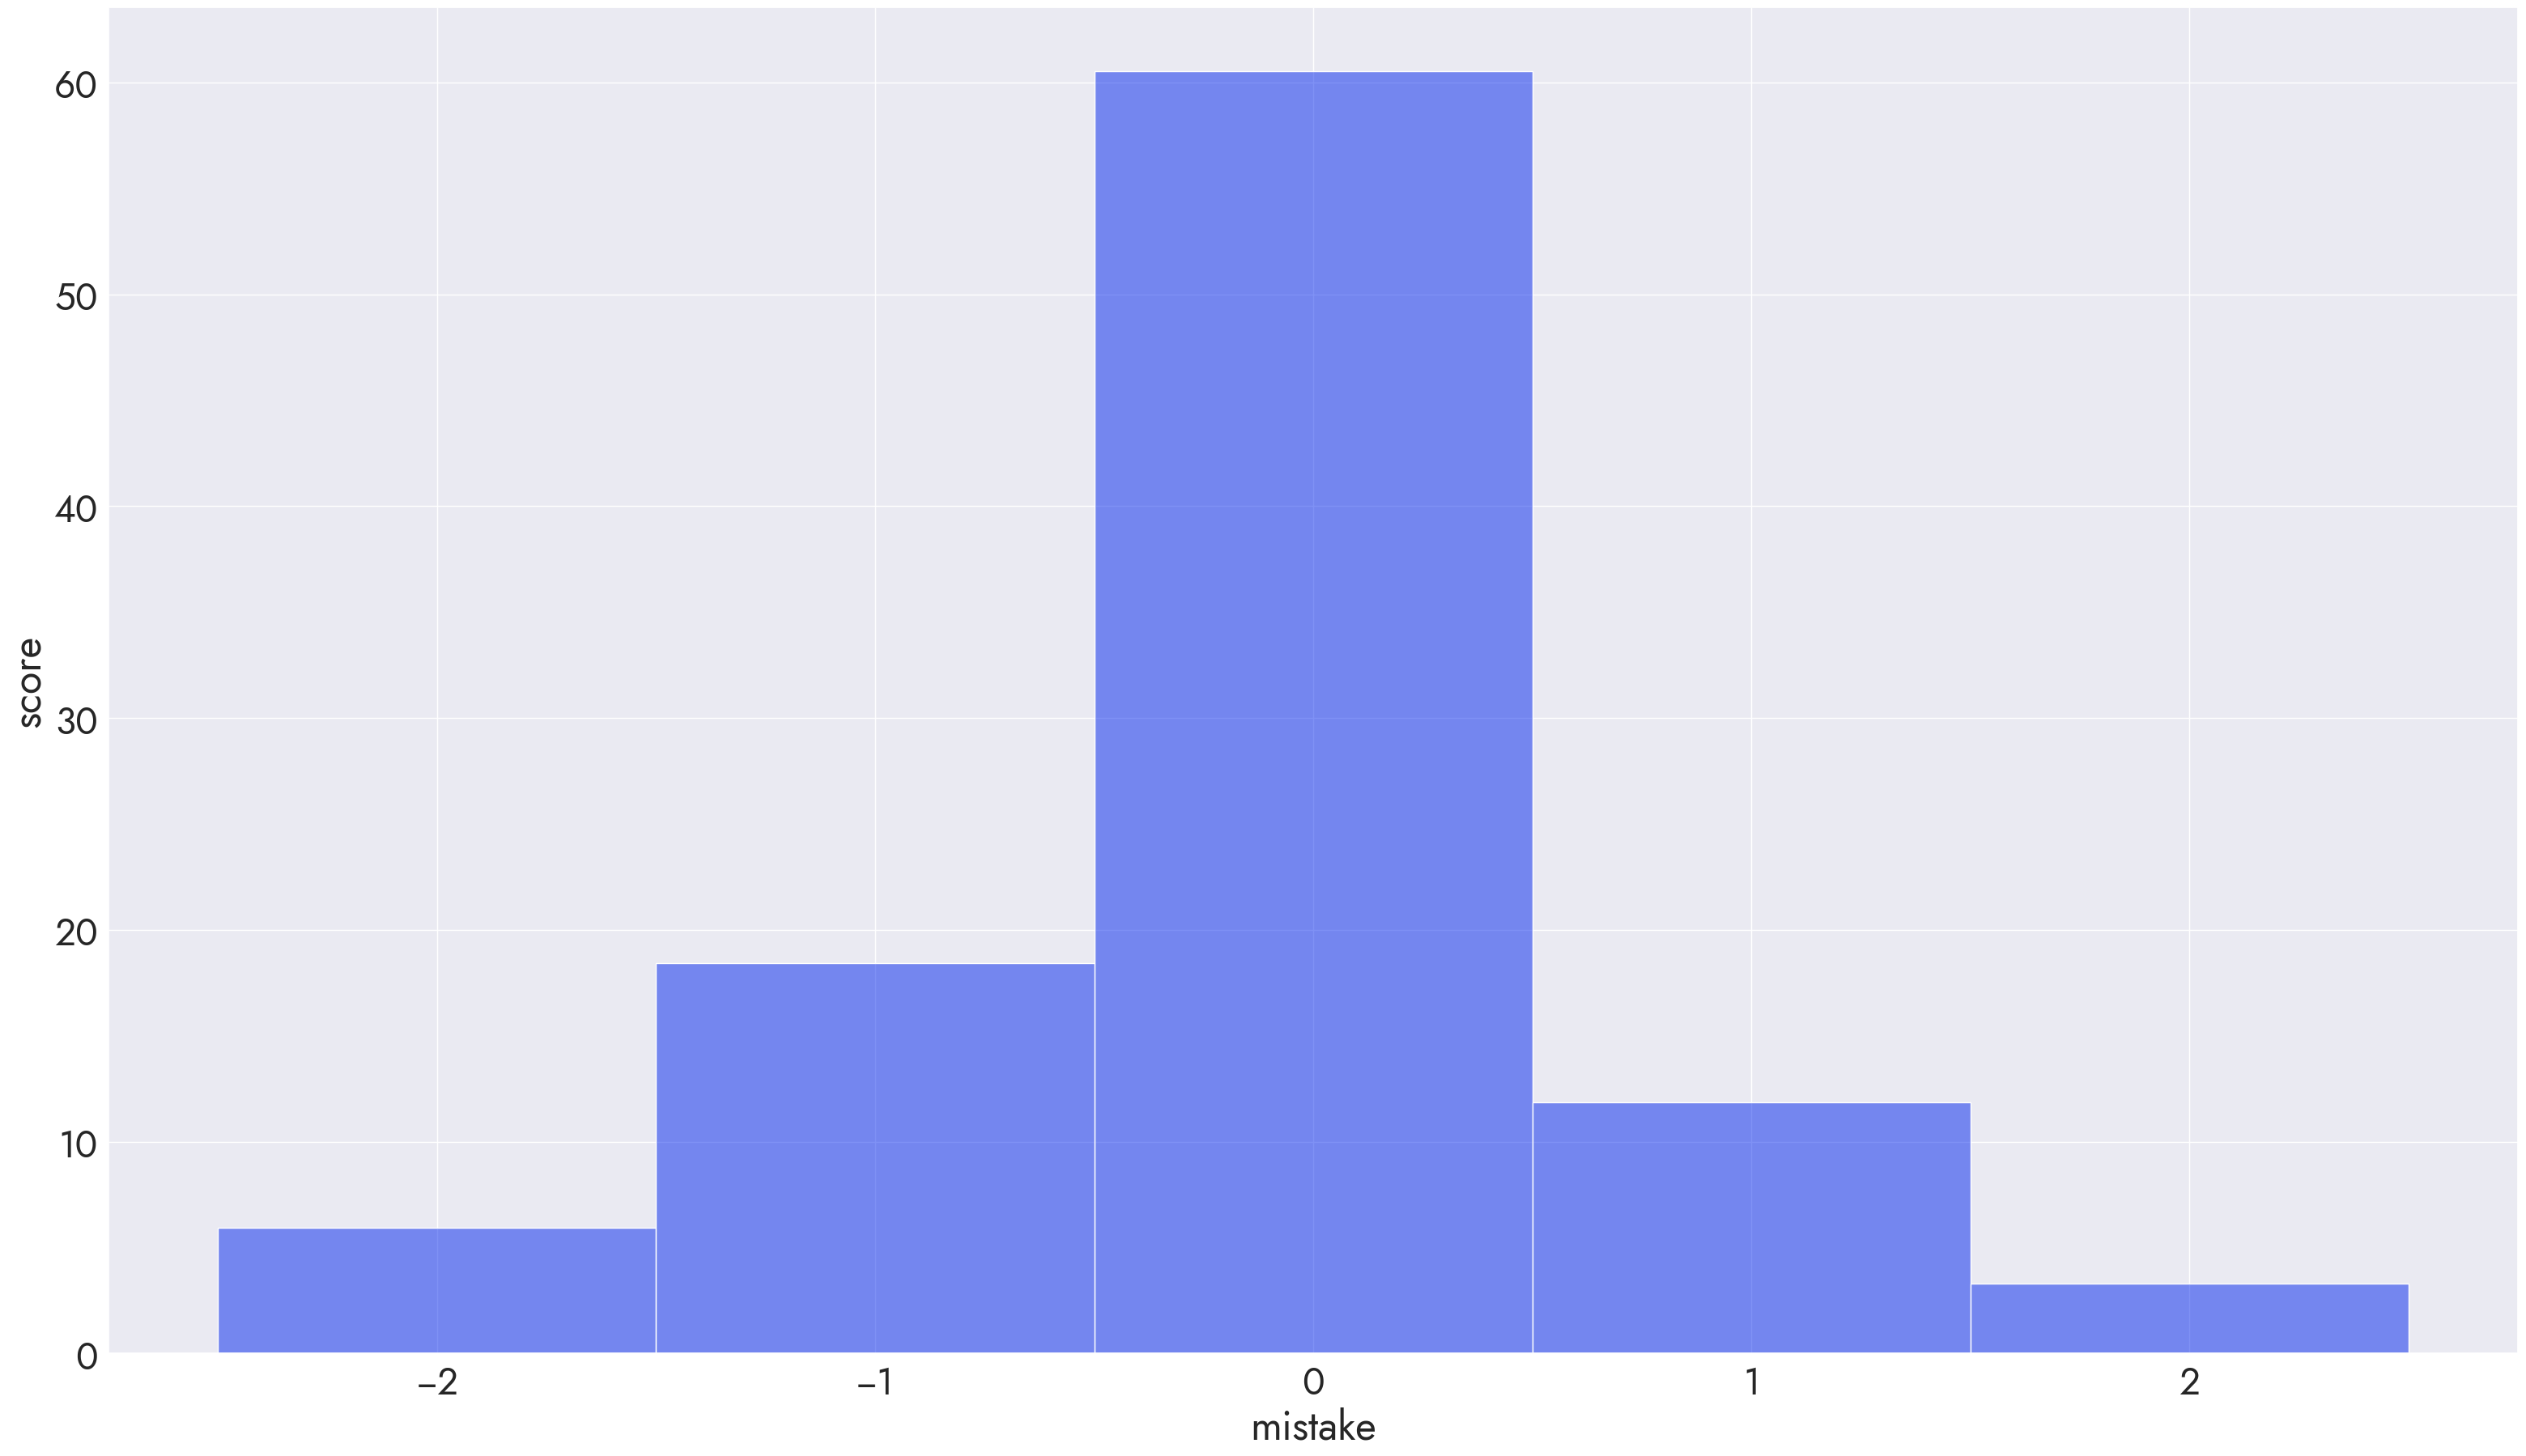

In [57]:
dnn_plot_mistakes = sns.histplot(data=pd.from_dummies(pd.DataFrame(test_predict)) - pd.from_dummies(pd.DataFrame(test_target)),
                                 stat='percent', legend=False, discrete=True)

dnn_plot_mistakes.set_xlabel('mistake')
dnn_plot_mistakes.set_ylabel('score');

In [58]:
dnn_plot_mistakes.figure.savefig(f'{VISUAL_PATH}/{SERIAL_TYPE}_mistakes_dnn.png', transparent=True)

Большинство наблюдений было предсказано правильно - при этом распределение ошибок имеет нормальный вид, в среднем модель ошибается в рамках соседних групп.